### Description - Best XGBoost model by @titericz

XGBoost model created by @titerics on kaggle and modified, also using "microbusiness_density" as target

### Libraries

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure",
       autolayout=True,
       figsize=(8, 4),
       titlesize=18,
       titleweight='bold',
      )
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=16,
       titlepad=10,
      )
plot_params = dict(color="0.75",
                   style=".-",
                   markeredgecolor="0.25",
                   markerfacecolor="0.25",
                  )
%config InlineBackend.figure_format = 'retina'


In [3]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

### 1. Basic Processing

In [4]:
train = pd.read_csv('./files/train.csv')
census = pd.read_csv('./files/census_starter.csv')
test = pd.read_csv('./files/test.csv')
sub = pd.read_csv('./files/sample_submission.csv')
print(train.shape, census.shape, test.shape, sub.shape)  # (122265, 7) (3142, 26) (25080, 3) (25080, 2)

# 1. concatenate train and test
train['istest'] = 0
test['istest'] = 1
raw = (pd.concat((train, test))          # concat train and test data, and sort by cfips first, and then sort by row_id for each cfips
       .sort_values(['cfips','row_id'])  # since row_id has a format 'cfips-first day of month', basically we sort by time
       .reset_index(drop=True)           # because we have both train and test, the index is confounded. so we drop the index first and then give the joined table a new index from 0
      )

# 2. change the type of the column 'first_day_of_month' to 'to_datetime'
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])

# 3. for each cfips, fill the 'county' and 'state' for the test part by forward fill
# - ffill: propagate last valid observation forward to next valid backfill
# - bfill: use next valid observation to fill gap.
raw['county'] = (raw
                 .groupby('cfips')['county']
                 .ffill()
                )

raw['state'] = (raw
                .groupby('cfips')['state']
                .ffill()
               )
# now, test data also have the 'county' and 'state' column value

# 4. - NEW COLUMNS: two year and month columns for both train and test
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw['first_day_of_month'] = raw['first_day_of_month'].astype('string')

# 5. - NEW COLUMNS: for each cfips, give each month a unique index from 0 to length of that group - 1.
#                   dcount become the unique index for each month for a cfips.
#                   dcount is the 0-started index for each cfips
raw["dcount"] = (raw
                 .groupby(['cfips'])['row_id']
                 .cumcount()
                )

# 6. - NEW COLUMNS: encode 'county + state' as unique codes; encode 'state' as unique codes
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw

(122265, 7) (3142, 26) (25080, 3) (25080, 2)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50


#### 1.1 Census_starter dataframe

In [5]:
def census_mapping(raw, census):
    
    # filling and formating
    census = (census
              .assign(cfips = census.cfips.astype('string'),
                      median_hh_inc_2017 = census.median_hh_inc_2017.astype(np.float64),
                      median_hh_inc_2019 = census.median_hh_inc_2019.astype(np.float64),
                      )
              .set_index('cfips')
              .ffill(axis=1)
    )

    # select parameters columns to map into raw dataframe
    parameters = [list(census.columns)[i:i+5] for i in range(0, len(census.columns), 5)]
    
    # new columns mapped in raw 
    raw_cols = ['pct_bb','pct_college','pct_foreign_born','pct_it_workers','median_hh_inc']
    #raw['cfips_year'] = raw.cfips.apply(lambda s: str(s)) + '_' + raw.year.apply(lambda s: str(s))
    
    for i, param in enumerate(raw_cols):
        # set dataframe into stack mode and rename columns
        df = census.loc[:, parameters[i]]
        df = (df
              .stack()
              .reset_index()
              .rename(columns={'level_1': 'parameter', 0: 'data'})
        )

        # setting lag between census data and train data
        df['year'] = pd.to_numeric(df.parameter.str.slice(start=-4)) + 2

        # bulid key for mapping
        df['year'] = df['year'].astype('string')
        df['cfips_year'] = df.cfips + '_' + df.year

        # mapping parameter
        dt = df.set_index('cfips_year').to_dict()['data']
        
        # make mapping into raw dataframe
        raw[param] = (raw.cfips.apply(lambda s: str(s)) + '_' + raw.year.apply(lambda s: str(s))).map(dt)
        
        if param == 'median_hh_inc':
            raw[param] = (raw[param] - raw[param].mean()) / raw[param].std()
        
        else:
            raw[param] = (raw[param] - raw[param].mean()) / raw[param].std()

    return raw

In [6]:
# inputs census data into raw dataframe
raw = census_mapping(raw, census)

In [7]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627


#### 1.2 Economic rates (CPI and Treasury 10Y)

In [8]:
# load economic rates
econ_rates = pd.read_csv('./files/economic_rates.csv',
                         parse_dates=['first_day_of_month'],
                         index_col='first_day_of_month',
                        )

# map economic rates (cpi and treasury 10Y) into raw dataframe
raw = (raw
       .assign(cpi_monthly = raw['first_day_of_month'].map(econ_rates['cpi_monthly']),
               treasury10y = raw['first_day_of_month'].map(econ_rates['treasury10y']),
              )
      )

econ_rates.head(3)

,cpi_monthly,treasury10y
first_day_of_month,,
2019-08-01,0.1,2.007
2019-09-01,0.2,1.499
2019-10-01,0.3,1.668


In [9]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,cpi_monthly,treasury10y
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.1,2.007
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.2,1.499
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.3,1.668


#### 1.3 Unemployment rate

In [10]:
unmp_rate = pd.read_csv('./files/state_unemployment.csv')

unmp_rate['id_map'] = (unmp_rate['first_day_of_month'] +'_' + unmp_rate['state'])
unmp_rate = unmp_rate.set_index('id_map')
unmp_rate.head(3)

,first_day_of_month,unemployment_rate,state
id_map,,,
2019-01-01_Alabama,2019-01-01,3.7,Alabama
2019-02-01_Alabama,2019-02-01,3.6,Alabama
2019-03-01_Alabama,2019-03-01,3.4,Alabama


In [11]:
# map the unemployment rate in each state
raw['pct_unemployment'] = (raw['first_day_of_month'] +'_' + raw['state']).map(unmp_rate['unemployment_rate'])
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,county_i,state_i,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,cpi_monthly,treasury10y,pct_unemployment
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,...,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.1,2.007,2.9
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,...,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.2,1.499,2.9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,...,0,0,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.3,1.668,3.0


### 2. Anomaly detection

In [12]:
lag = 1

# .shift(lag): for each cfips, shift its density column by lag=1, so the density in each first row will be NAN. -> you get a column with the length = len('density')
# .bfill(): fill NaN with the next valid density, so the density in each cfips' first row will be the original value, but note that
#           1001's density from 2022-12-01 to 2023-06-01 will be back filled by the first density of 1003 (the next cfips), in this new column 'mbd_lag_1'.
#           but, it turns out that doesn't really matter
# NOTE THAT, in the engineering, 'mbd_lag_1' is overwrite by new feature
raw[f'mbd_lag_{lag}'] = (raw
                         .groupby('cfips')['microbusiness_density']
                         .shift(lag)
                         .bfill()
                        )

# basically, 'dif' means the 'percentage increment' of the density from the previous month to this month
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

# if there are zeros in density, then we need to deal with special cases:
#    density  mbd_lag_1  div  fillna  clip  diff
#       1         1       1                 -> 0   
#       2         1       2                 -> 1
#       0         2       0                 -> -1
#       0         0      inf                -> inf     special cases
#       4         0      inf                -> inf     special cases
#      Nan        4      Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0

# --------------------------------------------
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
#    density  mbd_lag_1  div  fillna   diff
#       1         1       1          -> 0   
#       2         1       2          -> 1
#       0         2       0          -> -1
#       0         0      inf         -> inf     special cases -> 0
#       4         0      inf         -> inf     special cases -> 0
#      Nan        4      Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0


raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
# #    density  mbd_lag_1  div  fillna   diff
# #       1         1       1          -> 0   
# #       2         1       2          -> 1
# #       0         2       0          -> -1
# #       0         0      inf         -> inf     special cases -> 0
# #       4         0      inf         -> inf     special cases -> 0 -> 1   # is 1 a reasonable number?
# #      Nan        4      Nan    -> 1 -> 0
# #      Nan        Nan    Nan    -> 1 -> 0
# #      Nan        Nan    Nan    -> 1 -> 0

# # -------------------------

raw['dif'] = raw['dif'].abs()

In [13]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,cpi_monthly,treasury10y,pct_unemployment,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,...,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.1,2.007,2.9,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,...,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.2,1.499,2.9,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,...,0.106671,0.031564,-0.463163,-0.045136,0.117627,0.3,1.668,3.0,2.884870,0.059265


#### Let's see which dcount (time point) has a SIGNIFICANT increase than the previous month!

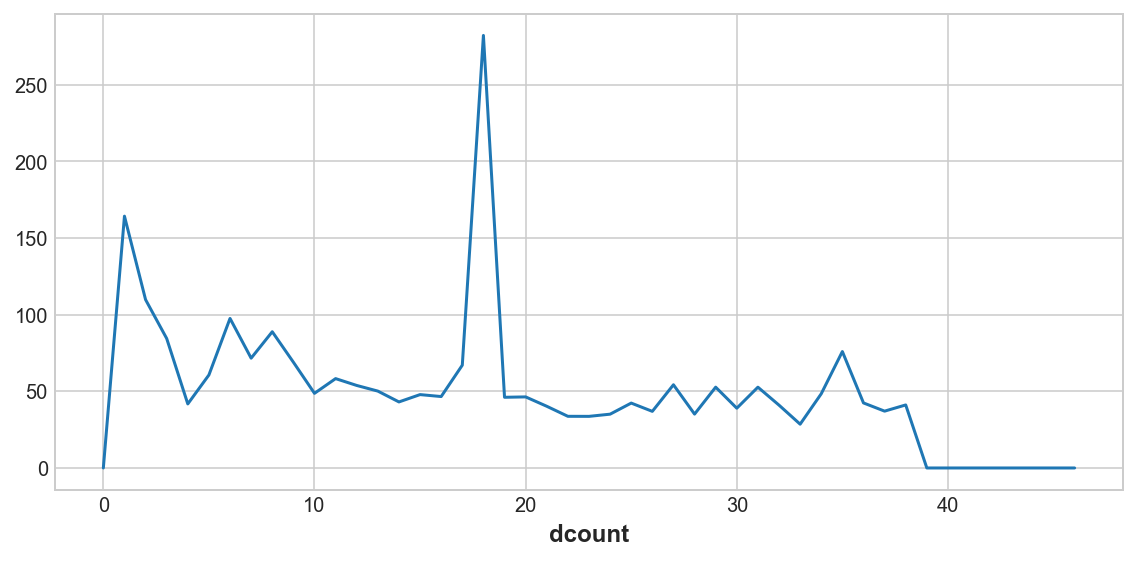

In [14]:
raw.groupby('dcount')['dif'].sum().plot();

#### Smoothing & Outlier correction

In [15]:
outliers = []   # record which cfips has outliners
cnt = 0         # the tot num of outliners
U = raw.copy()
for o in tqdm(raw.cfips.unique()):     # each cfips
    
    indices = (raw['cfips']==o)        # get all the idx for that cfips
    tmp = raw.loc[indices].copy().reset_index(drop=True)   # get all the rows for the cfips, reset_index make each tmp index from zero
    var = tmp.microbusiness_density.values.copy()          # copy density data for the current cfips
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(38, 0, -1):         # idx 37 ~ 3. Note: 0 ~ 38 is training data
                                       # why not consider 38? 2?  # i think you can even set it to 0
        thr = 0.20*np.mean(var[:i])    # use 20% average of the points before current point i as the anomaly value TH
        difa = abs(var[i]-var[i-1])    # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend
        if (difa>=thr):                # so we 'lift' all the previous values to the same 'stage' of the current point
            var[:i] *= (var[i]/var[i-1])
            
            outliers.append(o)         # save which cfips has outliers
            cnt+=1                     # total count
    
    # why not set the above for loop as range(37,0,-1)? so we don't need the line below
    #var[0] = var[1]*0.99               # why do this hard code 0.99? make the first -> second unchanged almost? 
    
    raw.loc[indices, 'microbusiness_density'] = var  # the smoothed density
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_7240\4122196428.py:16: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
C:\Users\DELL\AppData\Local\Temp\ipykernel_7240\4122196428.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
C:\Users\DELL\AppData\Local\Temp\ipykernel_7240\4122196428.py:16: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1])
C:\Users\DELL\AppData\Local\Temp\ipykernel_7240\4122196428.py:14: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i]-var[i-1])    # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend


(531, 860)

<AxesSubplot:xlabel='dcount'>

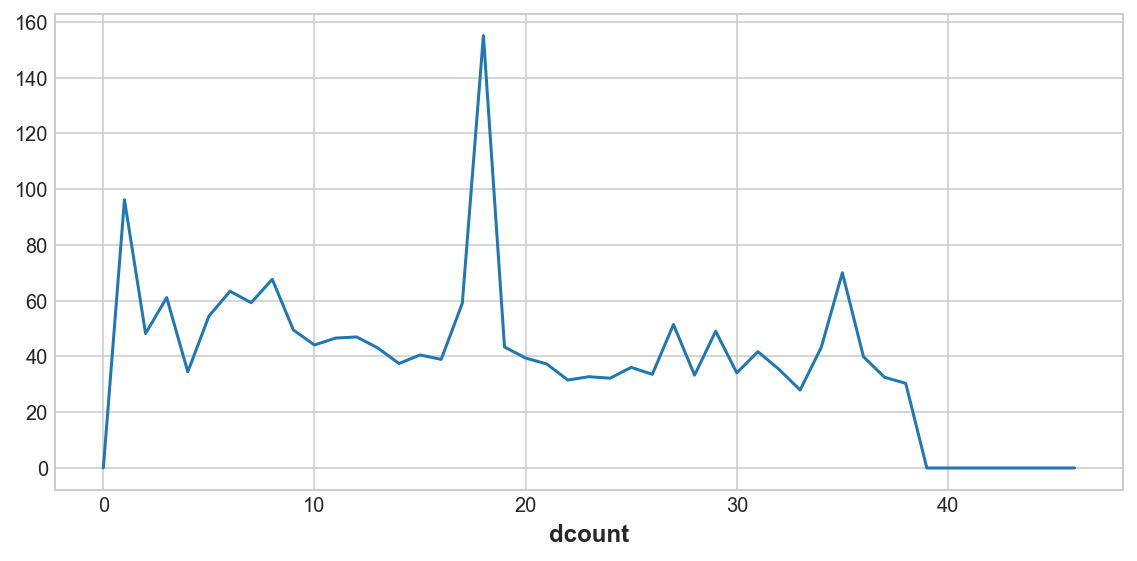

In [16]:
# plot again
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot:xlabel='dcount'>

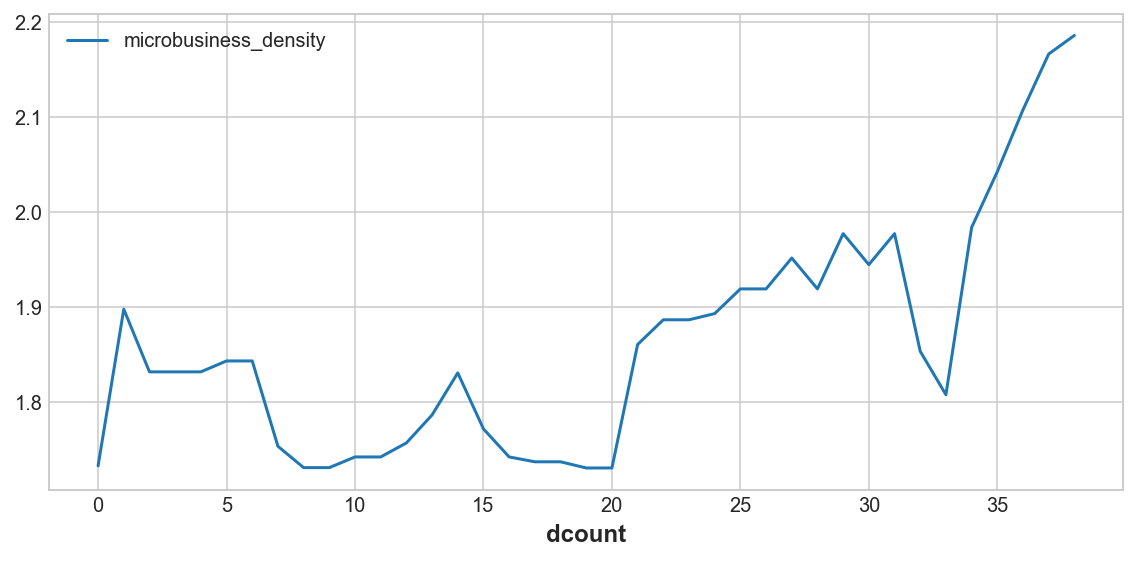

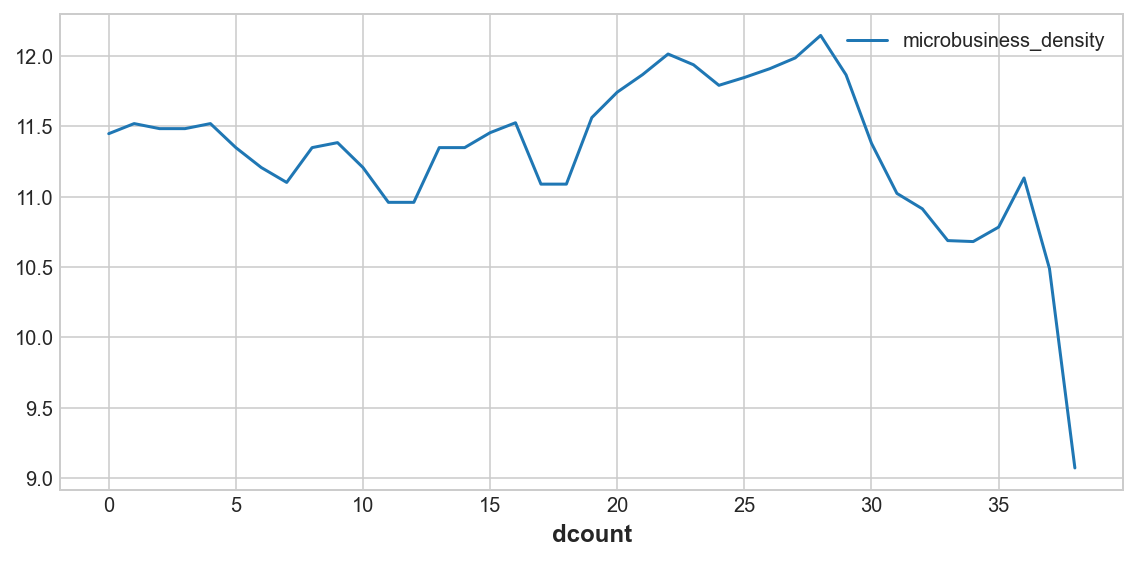

In [17]:
# plot two cfips density change over time
raw.loc[raw.cfips == 1013].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

### 3. SMAPE is a relative metric so target must be converted.

In [18]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)  # shift UP
raw['target'] = raw['target']/raw['microbusiness_density'] - 1   # next / this month - 1 = the next month increment
                                                                 # NOTE: dcount = 38 doesn't have target value - not next month to compare   
# two special cases, hard code to 0.0
raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

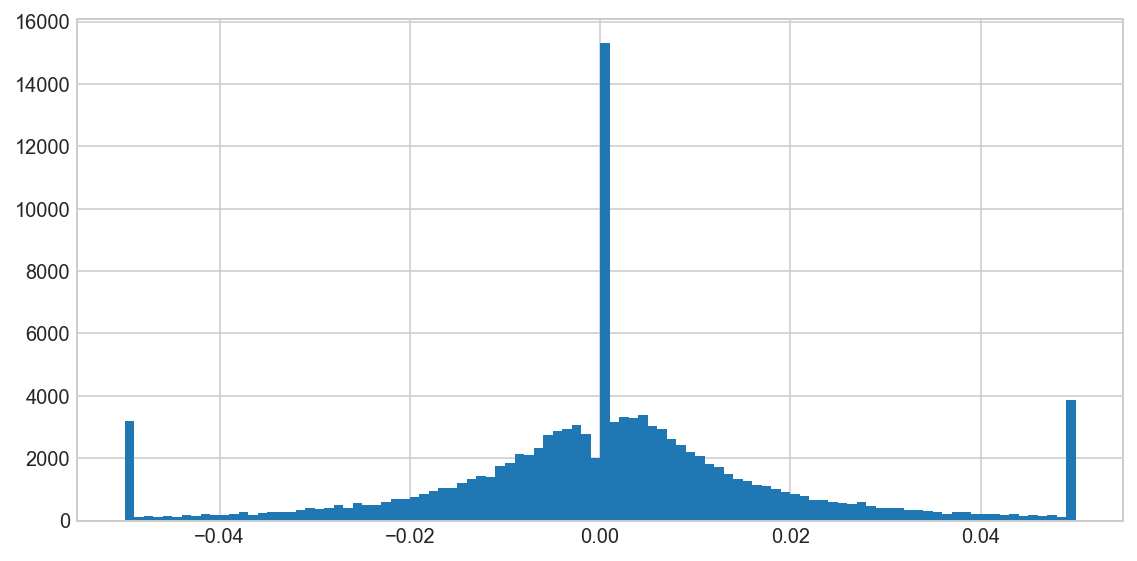

In [19]:
raw['target'].clip(-0.05, 0.05).hist(bins=100);

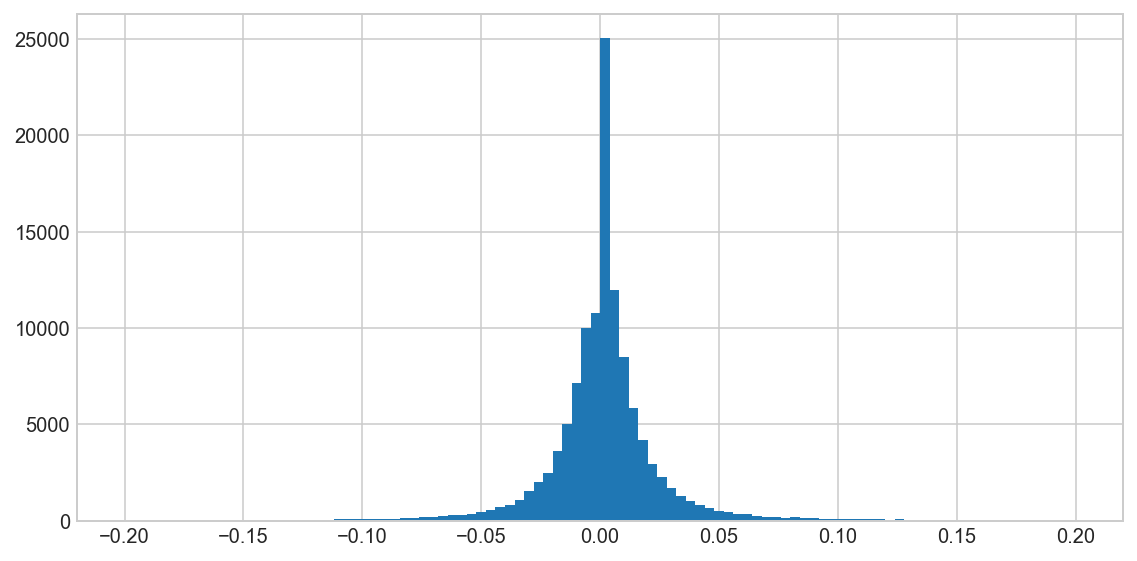

In [20]:
raw['target'].clip(-0.2, 0.2).hist(bins=100);

#### COLUMN 'lastactive'

In [21]:
# for each cfips, get the last active value and assign it to the NEW column 'lastactive'
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

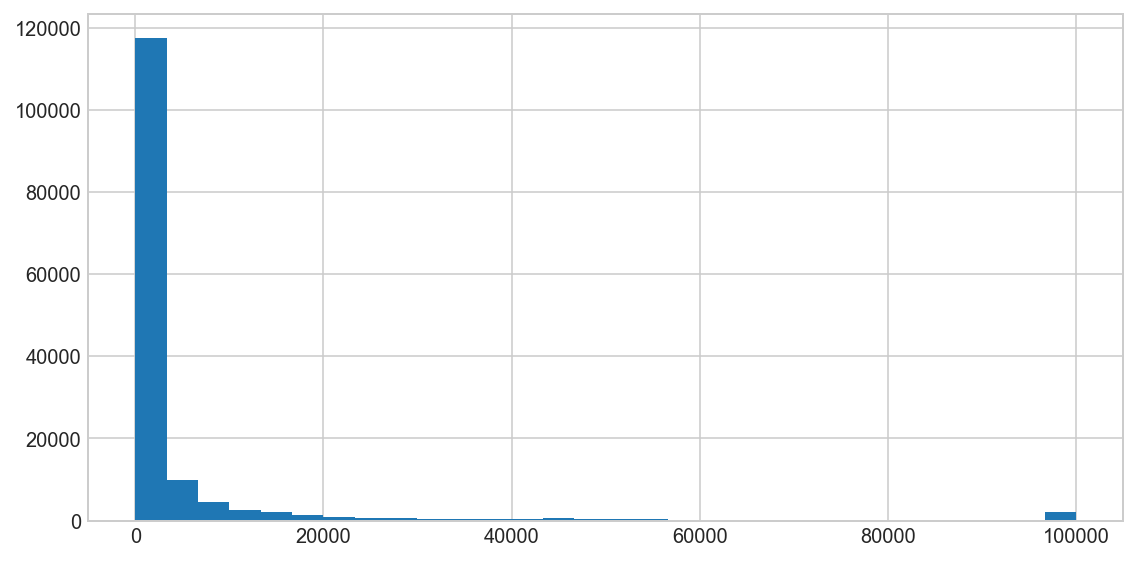

In [22]:
raw['lastactive'].clip(0, 100000).hist(bins=30);

#### COLUMN 'lasttarget'

In [23]:
def last_target(raw, ts=28):
    dt = (raw
          .loc[raw.dcount==ts]
          .groupby('cfips')['microbusiness_density']
          .agg('last')
         )
    
    raw['lasttarget'] = raw['cfips'].map(dt)
    
    return raw

raw = last_target(raw)

In [24]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,pct_it_workers,median_hh_inc,cpi_monthly,treasury10y,pct_unemployment,mbd_lag_1,dif,target,lastactive,lasttarget
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,...,-0.045136,0.117627,0.1,2.007,2.9,3.007682,0.000000,-0.040833,1472.0,3.286307
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,...,-0.045136,0.117627,0.2,1.499,2.9,3.007682,0.040833,0.059265,1472.0,3.286307
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,...,-0.045136,0.117627,0.3,1.668,3.0,2.884870,0.059265,-0.020489,1472.0,3.286307


### 4. Feature Engineering

In [25]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    '''
    e.g.,
    target = 'target'
    target_act = 'active'
    lags = 4
    '''
    
    feats = []
    for lag in range(1, lags):  # 1 ~ 3
        
        # for each cfips, shift the 'target' column by 1,2 and 3
        # the original 'target' column has values from 0 to 37, note that dcount = 38 (2022-10-01) doesn't have a target value 
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        
        # for each cfips, the diff between the current avtive value and the previous 1,2,and 3 months' active values
        # the original 'active' column has values from 0 to 38
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        
        # the shifted 'target' and 'active' are taken as features
        # basically, for each month, the previous 1,2,3 months' target and active are taken into consideration
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
    
    # the sum of the previous 2,4,6 months 'target' value
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = (raw
                                             .groupby('cfips')[f'mbd_lag_{lag}']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )   
        
        ## the diff between the previous month and the sum of previous 6 months. the original notebook doesn't use it
        ##raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        
        feats.append(f'mbd_rollmea{window}_{lag}')
    
    for window in [1, 2, 3]:
        raw[f'cpi_rollmea{window}_{lag}'] = (raw
                                             .groupby('cfips')['cpi_monthly']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )


        feats.append(f'cpi_rollmea{window}_{lag}')

    for window in [2, 4, 6]:
        raw[f'unmp_rollmea{window}_{lag}'] = (raw
                                             .groupby('cfips')['pct_unemployment']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )


        feats.append(f'unmp_rollmea{window}_{lag}')
    
    return raw, feats

In [26]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 4)

# the state code is a feature
features = ['state_i','pct_bb','pct_college','pct_foreign_born','pct_it_workers','median_hh_inc']
features += feats
print(features)

raw.loc[raw.dcount==38, features].head(10)

['state_i', 'pct_bb', 'pct_college', 'pct_foreign_born', 'pct_it_workers', 'median_hh_inc', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1', 'cpi_rollmea1_1', 'cpi_rollmea2_1', 'cpi_rollmea3_1', 'unmp_rollmea2_1', 'unmp_rollmea4_1', 'unmp_rollmea6_1']


,state_i,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,...,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1,cpi_rollmea1_1,cpi_rollmea2_1,cpi_rollmea3_1,unmp_rollmea2_1,unmp_rollmea4_1,unmp_rollmea6_1
38,0,0.757171,0.416696,-0.428150,-0.772171,0.302006,0.006152,9.0,0.005498,17.0,...,11.0,0.011650,0.034969,0.027467,0.4,0.8,0.9,5.3,10.5,15.8
85,0,1.013105,1.029406,-0.235576,-0.356722,0.563112,0.002170,31.0,-0.017601,-225.0,...,-366.0,-0.015431,-0.017278,0.049618,0.4,0.8,0.9,5.3,10.5,15.8
132,0,-1.173001,-1.228867,-0.375629,-0.252860,-1.288703,0.020921,5.0,0.008439,7.0,...,3.0,0.029359,0.033948,0.033966,0.4,0.8,0.9,5.3,10.5,15.8
179,0,0.053351,-1.211361,-0.550697,0.370313,-0.131163,-0.021367,-5.0,0.017391,-1.0,...,-7.0,-0.003976,0.010248,0.028286,0.4,0.8,0.9,5.3,10.5,15.8
226,0,0.426589,-0.948771,-0.060508,-0.252860,-0.324813,-0.010949,-9.0,0.008589,-2.0,...,0.0,-0.002360,0.033137,0.038372,0.4,0.8,0.9,5.3,10.5,15.8
273,0,-1.599558,-1.438939,-0.568203,-1.083758,-1.366467,0.012987,1.0,0.013158,2.0,...,3.0,0.026145,0.052992,0.080770,0.4,0.8,0.9,5.3,10.5,15.8
320,0,-0.213247,-0.738699,-0.498176,-0.045136,-0.606535,0.009036,3.0,0.027864,12.0,...,22.0,0.036900,0.098454,0.171279,0.4,0.8,0.9,5.3,10.5,15.8
367,0,0.447917,-0.668675,-0.393136,-0.356722,-0.241375,-0.003180,-8.0,0.007609,11.0,...,16.0,0.004429,0.027747,0.034010,0.4,0.8,0.9,5.3,10.5,15.8
414,0,-0.117272,-0.668675,-0.498176,0.993486,-0.673991,-0.040201,-16.0,-0.012407,-21.0,...,-28.0,-0.052608,-0.015697,-0.023285,0.4,0.8,0.9,5.3,10.5,15.8
461,0,-0.063952,-1.403927,-0.498176,-0.460584,-0.768498,-0.012605,-3.0,0.000000,-3.0,...,-5.0,-0.012605,0.000338,-0.098884,0.4,0.8,0.9,5.3,10.5,15.8


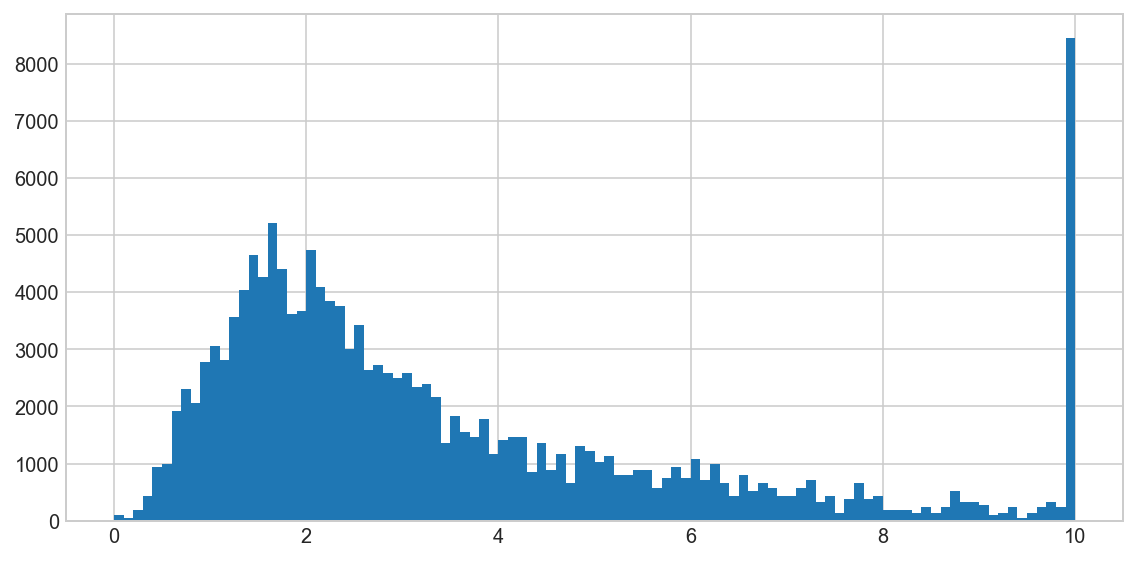

In [27]:
# why do we have to care about 'lasttarget'?
# ' basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
#   NOTE: this is the actual density value! not the target value. why 28?'
raw['lasttarget'].clip(0,10).hist(bins=100);

### 5. Model

What's the meaning of the blacklist? how to get it? see section 6

In [33]:
blacklist = ['North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont']

blacklistcfips_new = [
1011,1019,1027,1029,1035,1037,1039,1049,1057,1067,1071,1075,1077,1091,1099,1101,1103,1105,1107,1119,1129,1131,1133,4001,
4009,4011,4012,4013,4021,5001,5003,5005,5011,5013,5019,5021,5025,5027,5031,5035,5039,5041,5043,5047,5057,5063,5065,5067,
5073,5077,5079,5081,5083,5091,5093,5095,5099,5107,5109,5111,5117,5121,5123,5125,5127,5129,5133,5137,5139,5141,5145,5147,
6003,6005,6015,6027,6033,6035,6051,6053,6093,6095,6105,6109,6115,8003,8007,8009,8011,8019,8021,8025,8027,8049,8051,8053,
8055,8057,8061,8065,8073,8075,8079,8083,8091,8099,8103,8105,8109,8111,8113,8115,8117,8121,8125,9007,10003,12013,12017,
12019,12029,12043,12061,12065,12067,12073,12075,12079,12099,12123,12127,13001,13003,13005,13007,13011,13017,13023,13025,
13027,13035,13037,13043,13055,13061,13063,13075,13079,13091,13093,13101,13105,13117,13119,13123,13125,13141,13143,13147,
13149,13155,13161,13167,13169,13171,13173,13189,13193,13199,13201,13205,13209,13213,13219,13225,13229,13231,13233,13239,
13243,13249,13251,13253,13259,13263,13265,13271,13273,13283,13287,13289,13291,13299,13301,13307,13309,13315,13319,13321,
15005,15007,16007,16013,16023,16025,16029,16031,16033,16035,16039,16045,16047,16061,16067,16069,16077,16081,17001,17003,
17009,17013,17015,17017,17019,17021,17033,17045,17047,17051,17059,17061,17063,17065,17067,17069,17071,17075,17077,17079,
17083,17085,17095,17101,17103,17105,17107,17109,17115,17117,17123,17125,17127,17133,17137,17145,17147,17151,17159,17167,
17169,17171,17173,17175,17177,17185,17189,17191,17193,18003,18007,18009,18013,18017,18019,18021,18027,18035,18037,18049,
18051,18053,18055,18059,18065,18073,18075,18079,18083,18085,18087,18091,18103,18107,18111,18113,18115,18125,18127,18129,
18137,18139,18143,18153,18159,18161,18165,18171,18179,21001,21003,21007,21013,21017,21019,21023,21025,21027,21035,21037,
21039,21043,21045,21047,21051,21053,21055,21057,21061,21063,21073,21077,21081,21087,21091,21093,21095,21099,21103,21105,
21109,21119,21121,21125,21127,21129,21131,21133,21135,21137,21141,21143,21145,21147,21149,21153,21159,21161,21169,21171,
21175,21187,21189,21191,21193,21197,21199,21201,21203,21205,21215,21217,21221,21225,21227,21231,21233,21235,21237,21239,
22001,22003,22007,22011,22015,22021,22023,22027,22031,22035,22041,22047,22049,22053,22057,22059,22065,22067,22069,22085,
22089,22091,22103,22109,22123,22127,23003,23009,23013,23021,23027,24013,24015,24029,24031,24039,24041,25011,25015,26003,
26007,26011,26019,26023,26025,26027,26029,26033,26041,26043,26051,26059,26061,26071,26079,26083,26089,26095,26097,26101,
26103,26111,26117,26119,26127,26129,26131,26141,26143,26155,26159,26161,27001,27005,27011,27013,27017,27019,27021,27023,
27027,27029,27031,27037,27043,27047,27051,27055,27063,27065,27069,27073,27075,27077,27079,27083,27087,27091,27095,27099,
27101,27103,27105,27111,27119,27125,27131,27133,27135,27143,27145,27147,27149,27155,27159,27165,27167,27169,28005,28007,
28009,28013,28017,28019,28021,28023,28035,28041,28045,28053,28055,28061,28063,28065,28069,28077,28079,28087,28091,28095,
28099,28111,28119,28123,28125,28129,28133,28135,28139,28141,28143,28147,28149,28153,28155,28157,29001,29005,29007,29009,
29013,29015,29017,29019,29023,29029,29033,29037,29041,29045,29049,29051,29055,29057,29059,29061,29063,29065,29067,29069,
29073,29075,29089,29097,29101,29109,29121,29123,29125,29129,29133,29135,29137,29139,29143,29151,29155,29157,29159,29161,
29167,29173,29175,29177,29179,29181,29183,29195,29199,29203,29209,29211,29213,29217,29223,29227,30005,30009,30011,30015,
30025,30027,30033,30035,30037,30045,30049,30055,30059,30067,30069,30071,30073,30077,30079,30085,30087,30089,30093,30101,
30103,30105,30107,30109,32001,32005,32009,32017,32023,32027,32029,32033,32510,33009,34017,34021,34027,36013,36021,36033,
36041,36051,36055,36057,36061,36089,36091,36103,36107,36109,36113,36115,36121,36123,37009,37011,37015,37017,37023,37029,
37031,37075,37079,37091,37095,37099,37103,37111,37115,37117,37123,37131,37141,37149,37167,37177,37187,37197,39001,39007,
39009,39015,39017,39019,39027,39037,39039,39043,39053,39067,39073,39083,39087,39105,39111,39113,39115,39117,39119,39121,
39123,39125,39129,39143,39153,39157,39159,39163,39167,40001,40005,40013,40023,40025,40027,40029,40033,40039,40043,40045,
40053,40057,40059,40067,40069,40081,40085,40099,40101,40105,40115,40121,40123,40127,40129,40133,40141,40145,40151,41007,
41011,41013,41015,41021,41023,41025,41031,41037,41041,41043,41051,41055,41057,41061,41063,42005,42009,42011,42013,42017,
42019,42023,42029,42067,42071,42083,42085,42093,42099,42105,42111,42123,42125,44005,44009,45005,45009,45025,45031,45033,
45049,45061,45069,45081,45087,45089,47005,47013,47019,47021,47023,47027,47035,47039,47051,47055,47057,47061,47067,47073,
47075,47083,47087,47095,47097,47099,47101,47103,47105,47109,47111,47121,47127,47129,47135,47145,47147,47151,47153,47163,
47169,47171,47175,47177,47183,47185,48001,48015,48017,48019,48025,48033,48035,48045,48047,48055,48057,48059,48063,48069,
48073,48075,48079,48081,48095,48097,48101,48103,48105,48107,48109,48115,48117,48119,48123,48125,48127,48129,48131,48133,
48137,48151,48153,48155,48163,48165,48171,48173,48175,48177,48179,48191,48197,48205,48207,48211,48217,48223,48225,48229,
48233,48237,48239,48241,48243,48247,48249,48253,48255,48261,48263,48265,48267,48269,48271,48275,48277,48283,48295,48299,
48301,48305,48307,48311,48315,48317,48319,48321,48323,48327,48333,48335,48343,48345,48347,48351,48357,48369,48371,48379,
48385,48389,48393,48401,48403,48405,48413,48417,48419,48421,48427,48433,48435,48443,48447,48453,48457,48461,48463,48465,
48469,48475,48481,48483,48487,48489,48495,48499,48501,48503,48505,48507,49007,49009,49023,49025,49027,49031,49037,49039,
51009,51025,51027,51029,51031,51037,51043,51047,51051,51053,51059,51071,51075,51077,51079,51081,51091,51097,51101,51103,
51113,51115,51119,51121,51135,51137,51139,51147,51159,51171,51173,51183,51195,51197,51530,51540,51600,51610,51678,51685,
51735,51810,51830,53001,53013,53019,53023,53031,53033,53037,53039,53041,53047,53051,53055,53065,53069,53071,53077,54001,
54005,54007,54009,54013,54015,54017,54019,54021,54023,54025,54027,54031,54033,54041,54043,54047,54049,54057,54059,54065,
54071,54073,54077,54083,54085,54089,54091,54095,54097,54099,54101,54105,54107,54109,55003,55007,55011,55017,55019,55025,
55029,55031,55039,55041,55047,55049,55051,55061,55065,55069,55071,55077,55078,55085,55091,55103,55115,55117,55119,55123,
55127,55131,56001,56003,56009,56011,56015,56019,56027,56031,56037,56045,
]

blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,
5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,
6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,
8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,
12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,
13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,
13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,
16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,
17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,
17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,
17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,
18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,
21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,
21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,
22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,
24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,
26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,
26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,
27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,
27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,
28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,
29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,
29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,
30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,
30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,
36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,
37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,
39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,
39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,
40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,
40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,
42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,
42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,
47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,
47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,
48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,
48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,
48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,
48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,
48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,
49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,
51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,
51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,
53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,
54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,
55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,
56037,56043,56045,12061,6095,49025,18073,29029,29097,48419,51830,30067,26095,18159,32001,54065,54027,13043,48177,55069,
48137,30087,29007,13055,48295,28157,29037,45061,22053,13199,47171,53001,55041,51195,18127,29151,48307,51009,16047,29133,
5145,17175,21027,48357,29179,13023,16077,48371,21057,16039,21143,48435,48317,48475,5129,36041,48075,29017,47175,39167,
47109,17189,17173,28009,39027,48133,18129,48217,40081,36021,6005,42099,18051,36055,53051,6109,21073,27019,6051,48055,8083,
48503,17021,10003,41061,22001,22011,21205,48223,51103,51047,16069,17033,41011,6035,47145,27083,18165,36055,12001,26159,
8125,34017,28141,55119,48405,40029,18125,21135,29073,55115,37149,55039,26029,12099,13251,48421,39007,41043,22015,37115,
54099,51137,22049,55131,17159,56001,40005,18017,28091,47101,27037,29005,13239,21019,55085,48253,51139,40101,13283,18049,
39163,45049,51113,
]
# [2100,2105,2110,2164,2180,2185,2195,2198,2220,2230,2282,13213,19005,19007,19017,19031,19033,19035,
# 19037,19039,19041,19045,19051,19053,19055,19059,19067,19069,19071,19077,19081,19093,19097,19099,19105,19107,19111,19115,
# 19125,19143,19157,19161,19165,19181,19185,19195,20005,20009,20011,20017,20019,20023,20025,20029,20033,20035,20037,20039,
# 20043,20047,20057,20065,20067,20069,20071,20073,20075,20081,20083,20097,20101,20105,20111,20115,20125,20129,20143,20145,
# 20147,20149,20167,20171,20179,20183,20185,20187,20189,20191,20199,20203,20205,20207,29009,29109,31007,31017,31019,31031,
# 31041,31047,31049,31053,31063,31065,31069,31071,31073,31075,31087,31091,31103,31107,31111,31113,31127,31131,31133,31135,
# 31139,31143,31149,31151,31161,31163,31169,31171,31173,31175,31179,31181,31185,35003,35006,35011,35015,35023,35027,35033,
# 35039,35047,35051,35053,35057,38003,38007,38009,38013,38021,38023,38027,38031,38033,38037,38039,38041,38043,38051,38057,
# 38067,38073,38075,38083,38087,38097,38101,40085,46003,46015,46019,46021,46023,46037,46039,46041,46043,46045,46051,46053,
# 46057,46059,46063,46067,46071,46073,46079,46085,46097,46099,46105,46107,46109,46111,46117,46123,49039,50003,50013,50017,
# 50019,50025,50027,
#]

In [34]:
# raw.loc[:, ['cfips', 'dcount'] + features]

In [35]:
# threshold
ACT_THR = 1.8
ABS_THR = 1.0

# define 3 new columns for use
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.0
raw['var_pred'] = np.nan

# VAL = []
BEST_ROUNDS = []

In [36]:
for TS in range(29, 38):  # from 29 to 37.  1) is it the reason why 'lasttarget' use 'dcount=28'?  
                          # the actual density pred you give is 30 to 38  
    print(TS)

    # --- define the model
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',   # why this objective?
        #objective='reg:squarederror',
        max_depth=6,
        tree_method="hist",                 # 
        n_estimators=4999,                  # iterations
        learning_rate=0.0075,
        max_leaves=31,    
        subsample=0.60,                     # sample used for each iteration
        colsample_bytree=0.50,              # features used for each iteration
        max_bin=4096,                       # 
        n_jobs=2,
        eval_metric='mae',                  # 
        early_stopping_rounds=70,
    )

    # --- get training data
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) & (raw.lasttarget>ABS_THR) 
    #                no test data   |    training month = [1,TS)             |                   1.8     |                    1
    #                                    why not use 0?                                                              
    #                                    because has undefined features, but does 1 has all the features?
    # 
    # note that for each cfips, the 'lastactive' across months are the same, so does the 'lasttarget' column
    # so, you either select all the rows or drop all the row for a cfips
    #
    # ‘lasttarget’: for each cfips, the density in dcount = 28 '2021-12-01'
    # 'lastactive': for each cfips, the last active value (in dcount = 38)  '2022-10-01'

    # --- get testing data
    valid_indices = (raw.istest==0) & (raw.dcount == TS)  # note: more cfips than training data, but we exclude some of them later

    # --- model fit
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),    # why clip ? the increase or decrease is confined in the range (-0.0043, 0.0045). reasonable?
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )

    # --- save best iteration
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)

    # --- pred the current validation set, note the pred is the increment comparing to TS+1
    ypred = model.predict(raw.loc[valid_indices, features])

    # becasue we pred the increment for the next month, so we need to add 1
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices, 'var_pred'] = ypred
    # if you multiple it with 'density' in TS, you get next month TS+1 density prediction
    raw.loc[valid_indices, 'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # --- ACTUALLY, WE ARE PREDICTING **TS+1** ---
    # 1. define two mappings, lastval and dt
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    # for all the current validation TS, get cfips and density
    # then, set cfips to index, so we make a dict -> cfips: the density for TS
    # e.g., { 'microbusiness_density':{1001: 3.2967808, 1003: 7.733397, 1005: 1.1866289, ...} }
    # this is a map for later use

    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    # e.g., { 'k':{1001: pred for TS+1 month ACTUAL density, 1003: , 1005: , ...} }
    # this is a map for later use

    # 2. define a tmp dataframe for the preds of TS+1
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    # get all the cfips's TS+1                                         the 2022-10-01 active |  'target' value in TS

    # ATTACH the mappings to df columns
    df['pred'] = df['cfips'].map(dt)         # put TS+1 density pred to 'pred' column of the TS+1 specific df
    df['lastval'] = df['cfips'].map(lastval) # put the TS density to 'lastval' column of df

    # FOR SOME CASES, WE DON'T WANT TO USE THE PREDICTIONS BY THE MODEL, INSTEAD, WE WANT TO USE THE TS DENSITY.
    # case1. for each cfips, if the last active in dcount=38 is smaller than ACT_THR, (which means the business scale is considered as small)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']

    # case2. for each cfips, if the TS actual density is smaller than ABS_THR, (which means the recent trend is small?)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']

    # case3. if the state is in the black list, then we don't use the pred above, instead, use the TS density
    #        how to get this blacklist?
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']

    # case4. if the cfips is in the black list, then we don't use the pred above, instead, use the TS density
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']

    # FINALLY, assign the pred to the 'ypred' column of the 'raw' dataframe
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    #          lastval is the actual density in TS, basically, you shift lag=1
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )   # smape if you simply use last density to predict TS+1
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))              # smape if you use the preds
    print()

    
ind = (raw.dcount >= 30) & (raw.dcount <= 38)
print( 'XGB SMAPE:', smape(raw.loc[ind, 'microbusiness_density'], raw.loc[ind, 'ypred']) )
print( 'Last Value SMAPE:', smape(raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last']) )

29
[0]	validation_0-mae:0.49351
[500]	validation_0-mae:0.01411
[869]	validation_0-mae:0.01087
TS: 29
Last Value SMAPE: 1.0868726017655663
XGB SMAPE: 1.0764271698823542

30
[0]	validation_0-mae:0.48746
[500]	validation_0-mae:0.01269
[653]	validation_0-mae:0.01200
TS: 30
Last Value SMAPE: 1.318087470449913
XGB SMAPE: 1.148659094242158

31
[0]	validation_0-mae:0.49316
[500]	validation_0-mae:0.01486
[959]	validation_0-mae:0.01118
TS: 31
Last Value SMAPE: 1.1258309832479911
XGB SMAPE: 1.1044214435575863

32
[0]	validation_0-mae:0.49995
[500]	validation_0-mae:0.01657
[1000]	validation_0-mae:0.00879
[1500]	validation_0-mae:0.00864
[2000]	validation_0-mae:0.00862
[2500]	validation_0-mae:0.00861
[3000]	validation_0-mae:0.00859
[3500]	validation_0-mae:0.00858
[3541]	validation_0-mae:0.00858
TS: 32
Last Value SMAPE: 0.897969439640235
XGB SMAPE: 0.8743998236913212

33
[0]	validation_0-mae:0.48932
[500]	validation_0-mae:0.01472
[706]	validation_0-mae:0.01320
TS: 33
Last Value SMAPE: 1.3686285670946

In [37]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount==34), ['cfips', 'microbusiness_density', 'ypred', 'ypred_last','error', 'error_last'] ].head(10)

,cfips,microbusiness_density,ypred,ypred_last,error,error_last
34,1001,3.346197,3.327088,3.313253,0.572704,0.989406
81,1003,8.507496,7.943058,7.907365,6.862242,7.312046
128,1005,1.191678,1.191761,1.186629,0.006928,0.424630
175,1007,1.275998,1.253346,1.247892,1.791144,2.227181
222,1009,1.773202,1.755801,1.748417,0.986139,1.407557
269,1011,0.937421,0.912085,0.912085,2.739729,2.739729
316,1013,1.983687,1.814297,1.807504,8.919995,9.294320
363,1015,2.724583,2.702155,2.691084,0.826566,1.237115
410,1017,1.468978,1.494419,1.487859,1.717001,1.277135
457,1019,1.117345,1.245721,1.245721,10.865198,10.865198


In [ ]:
raw.pct_it_workers.max()

#### 5.1 File to make ensemble

In [ ]:
(raw
 .loc[(raw.dcount >= 30) & (raw.dcount <= 38), ['row_id','cfips','dcount','microbusiness_density','ypred','ypred_last']]
 .rename(columns={'ypred': 'ypred_mod', 'ypred_last': 'ypred_mod_last'})
 .to_csv('./xgboost_ensemble/xgiba_mbd_mod.csv', index=False)
)

In [ ]:
for ts in range(29,38):
    idx_train = (raw.dcount < ts) & (raw.istest==0) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) & (raw.lasttarget>ABS_THR) \
                & (raw.target > 0) #& (raw.target <= 0.0085)
    print(f'len {ts}:', len(raw.loc[idx_train, 'target']))
    # raw.loc[idx_train, 'target'].std()


In [ ]:
# raw.loc[:, ['row_id','cfips','dcount','microbusiness_density','target','var_pred','ypred','ypred_last']].head(50)

In [ ]:
dc = 29
print('target median: ', raw.loc[raw.dcount.isin([dc]), ['target']].median())
print('target mean: ', raw.loc[raw.dcount.isin([dc]), ['target']].mean())

raw.loc[raw.dcount.isin([dc]), ['target']].hist(bins=200);

In [ ]:
print('target median: ', raw.loc[raw.dcount.isin([dc]), ['var_pred']].median())
print('target mean: ', raw.loc[raw.dcount.isin([dc]), ['var_pred']].mean())

raw.loc[raw.dcount.isin([dc]), ['var_pred']].hist(bins=200);

### 6. Some post-hoc analysis after training and validation

#### 6.1 which state has the most significant diff between the error (by pred) and the error_last (by last value pred)

for example, it is better to use the actual xgb prediction for the district of columbia, instead of the last prediction.

In [ ]:
dt = raw.loc[(raw.dcount>=30) & (raw.dcount<=38)].groupby('state')[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=True)
dt

In [ ]:
dt.iloc[-10:,:]

THIS IS WHERE THE BLACK LIST COMES FROM!!!

#### 6.2 which month has the biggest error

In [ ]:
dt = raw.loc[(raw.dcount >= 30) & (raw.dcount <= 38)].groupby('dcount')[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt.loc[dt['hit'] > 0]
dt

#### 6.3 stat err for each cfips and dcount, find out which dcount in which cfips has the biggest error diff between error_last and error

In [ ]:
dt = raw.loc[(raw.dcount >= 30) & (raw.dcount <= 38) ].groupby(['cfips','dcount'])[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False).reset_index()
dt.loc[dt['hit']>0]
dt.head(20)

TOP 300 cfips with big diff, maybe duplicate inside

In [ ]:
dt.loc[dt['hit']>0].cfips.values[:300]

#### 6.4 TOP county that shouldn't use pred. instead, we should use last_value!

In [ ]:
blacklist_states = set(raw.loc[raw.state.isin(blacklist)].copy().cfips.unique())

In [ ]:
dt = raw.loc[(raw.dcount >= 30) & (raw.dcount <= 38)].groupby('cfips')[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt = dt.loc[dt['hit'] > -0.12]
dt.hit.hist(bins=50)

In [ ]:
len(set(dt.index) - blacklist_states)

In [ ]:
len(set(dt.index).intersection(set(blacklistcfips)))

In [ ]:
lista=list(set(dt.index) - blacklist_states)
lista.sort()
len(lista)
','.join([str(i) for i in lista])

#### 6.5

In [ ]:
dt = raw.loc[(raw.dcount >= 30) & (raw.dcount <= 38) ].groupby(['cfips','dcount'])[['error', 'error_last']].last()
dt['miss'] = dt['error'] > dt['error_last']
# dt

**for each county, the % that our XGB pred does worse than last preds**

In [ ]:
dt = dt.groupby('cfips')['miss'].mean()
dt

**if 50% XGB preds is worse than the last pred, show me these county**

In [ ]:
dt = dt.loc[dt>=0.50]
dt.index

In [ ]:
','.join([str(i) for i in dt.index])

#### 6.6

In [ ]:
df = raw.loc[(raw.dcount >= 30)&(raw.dcount <= 38) ].copy().reset_index(drop=True)
print( smape(df['microbusiness_density'], df['ypred']) )

In [ ]:
dt = df.groupby(['cfips','dcount'])[['error', 'error_last']].sum()
dt['hit'] = 1*(dt['error'] < dt['error_last'])
dt

In [ ]:
dt = dt.groupby('cfips')['hit'].mean().sort_values(ascending=True)
dt

In [ ]:
# top 800 county that should use last_value prediction, NOT XGB predictions
toplist = list(dt.index[:800])
#print(toplist)

# 
df.loc[df.cfips.isin(toplist), 'ypred'] = df.loc[df.cfips.isin(toplist), 'ypred_last']
print( smape(df['microbusiness_density'], df['ypred']) )

#### 6.7 how many cfips error were smaller than last_value

In [ ]:
dt = raw.loc[(raw.dcount >= 30) & (raw.dcount <= 38)].groupby(['dcount', 'cfips'])[['error', 'error_last']].mean().reset_index()
dt['hit'] = (dt['error'] < dt['error_last'])*1
dt = dt.groupby('cfips')['hit'].sum().sort_values(ascending=False)
dt = dt.loc[(dt >= 1) & (dt <= 4)].copy()
list(dt.index)
# dt.value_counts()

C:\Users\DELL\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


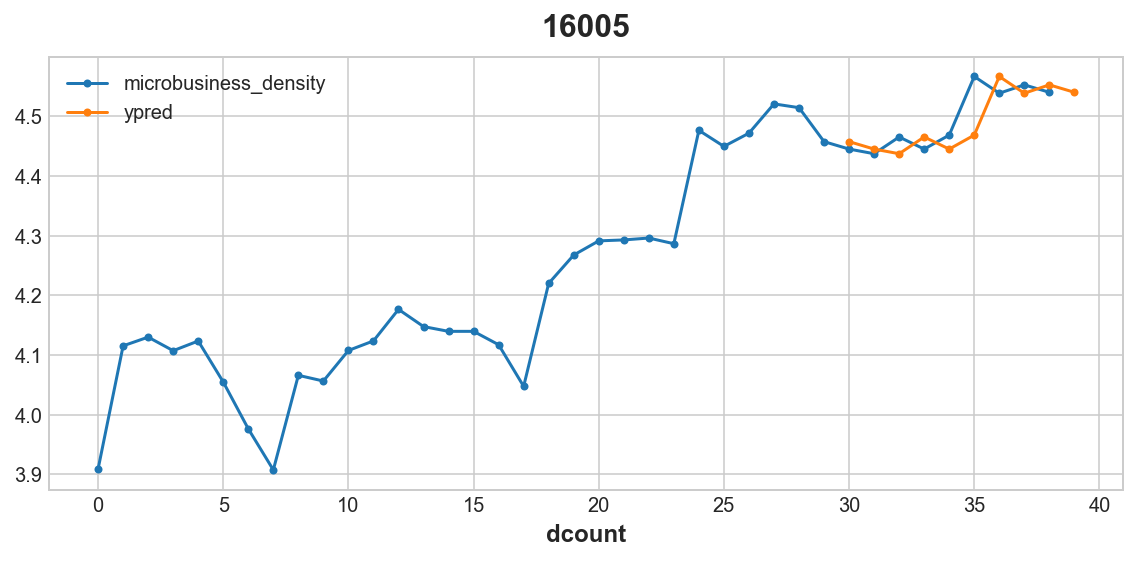

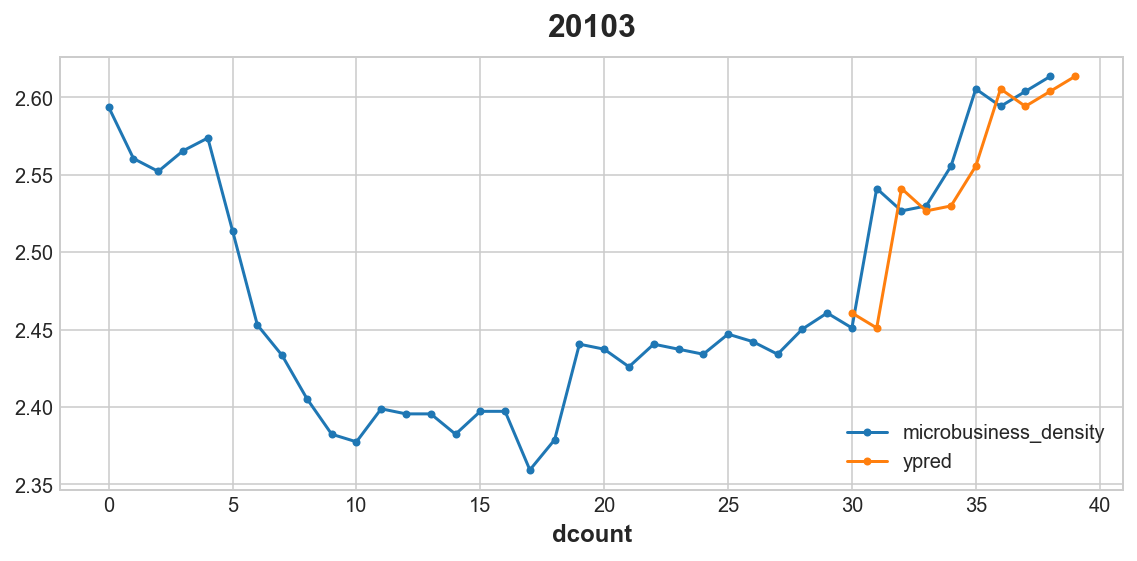

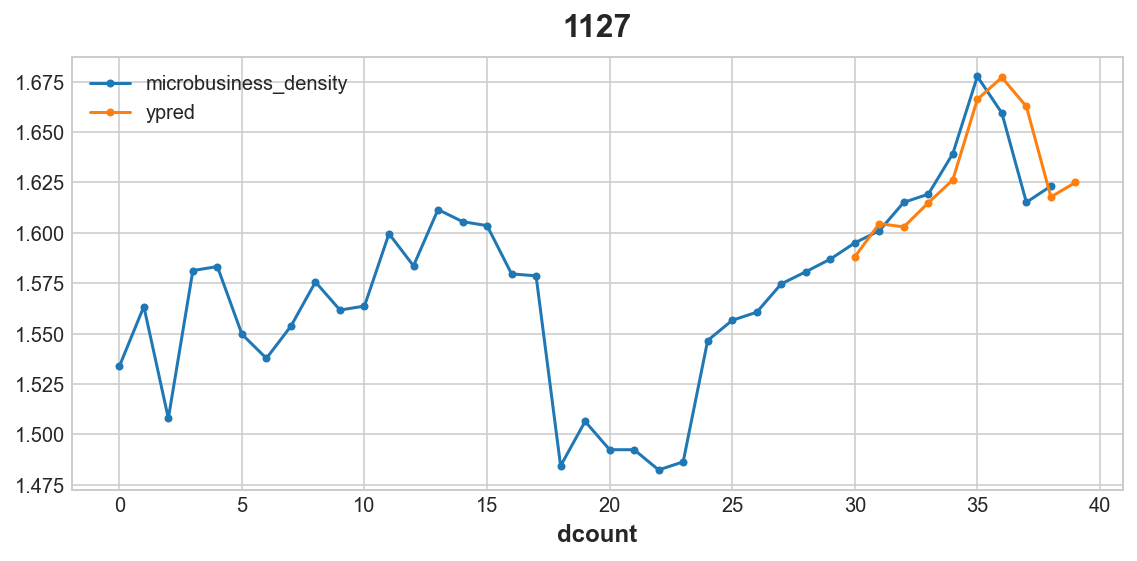

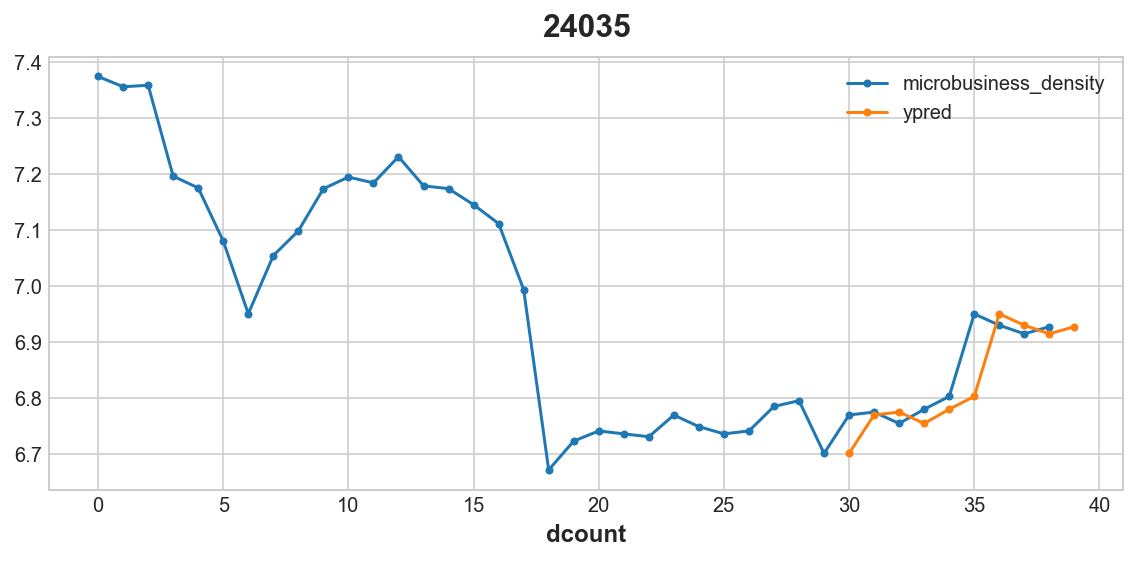

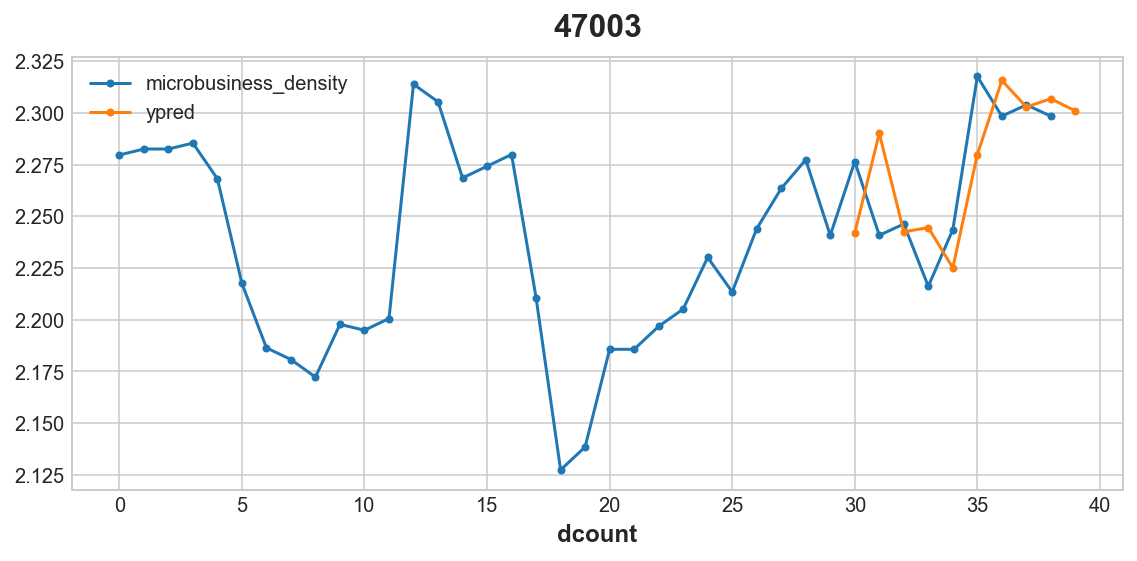

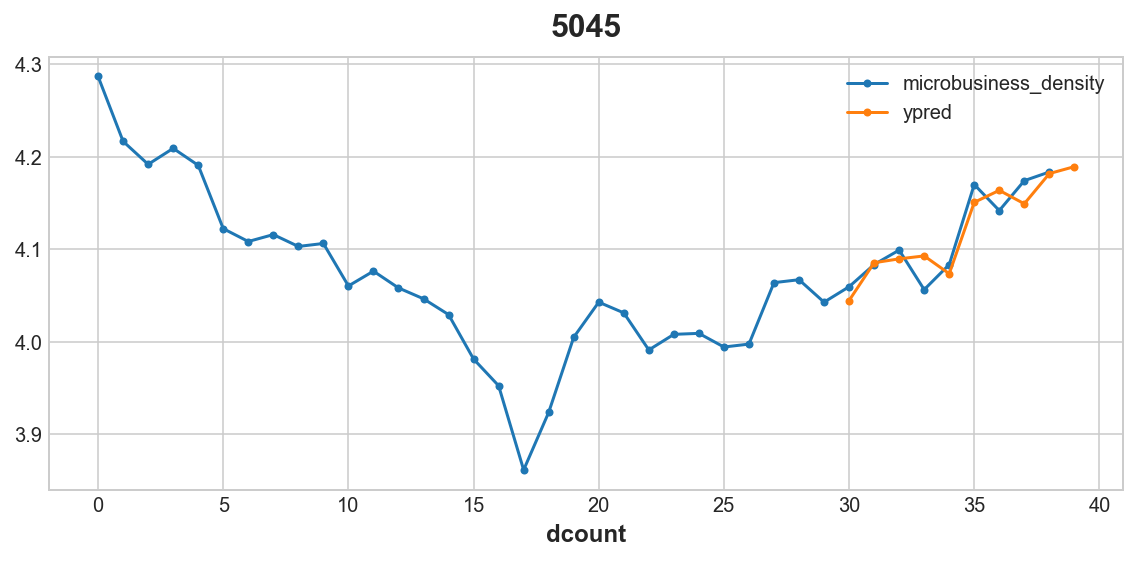

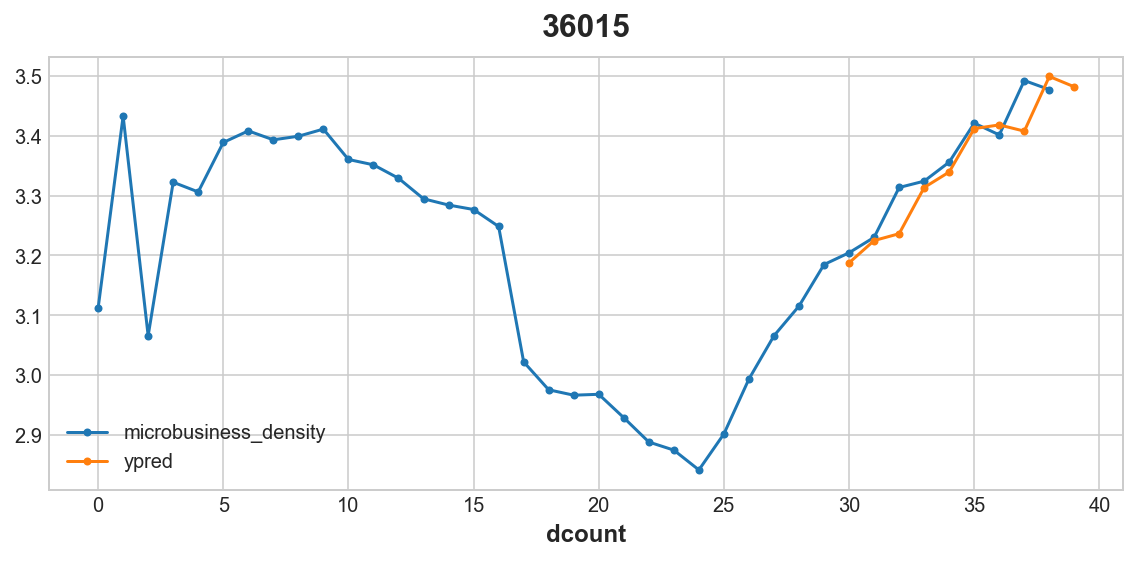

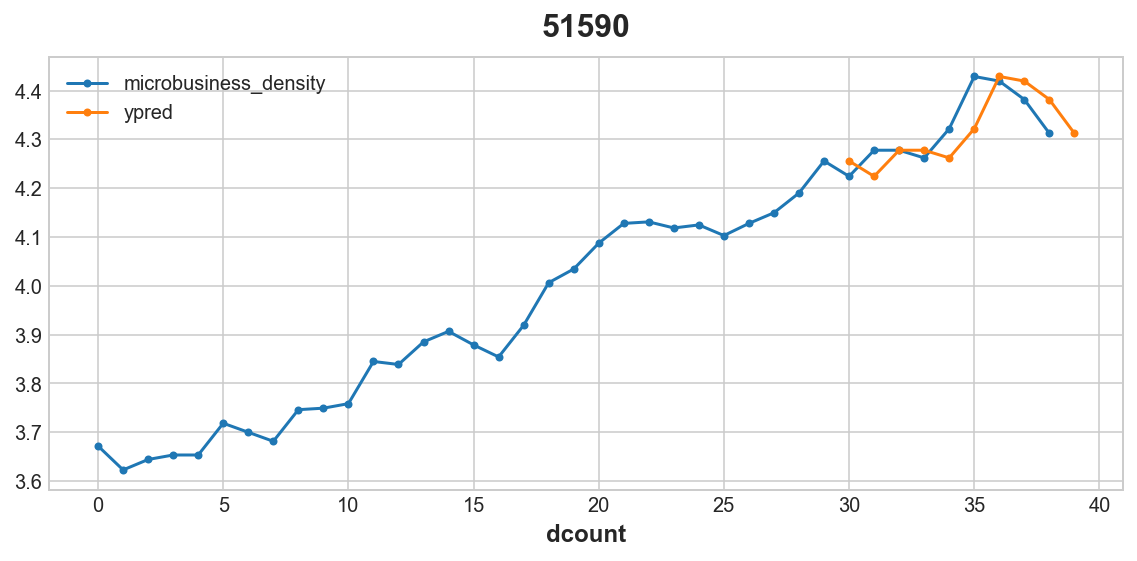

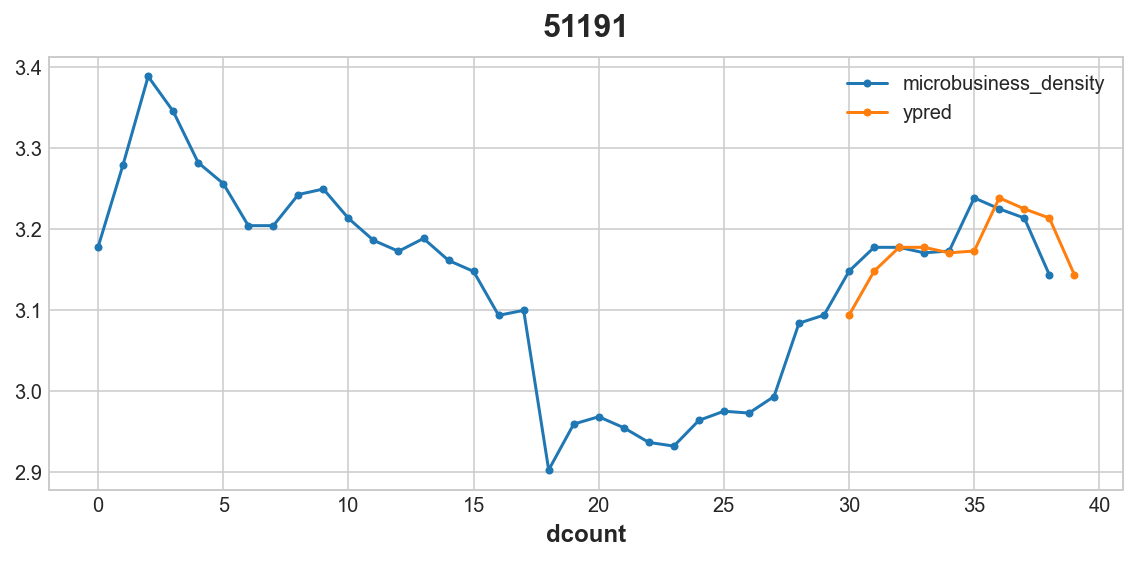

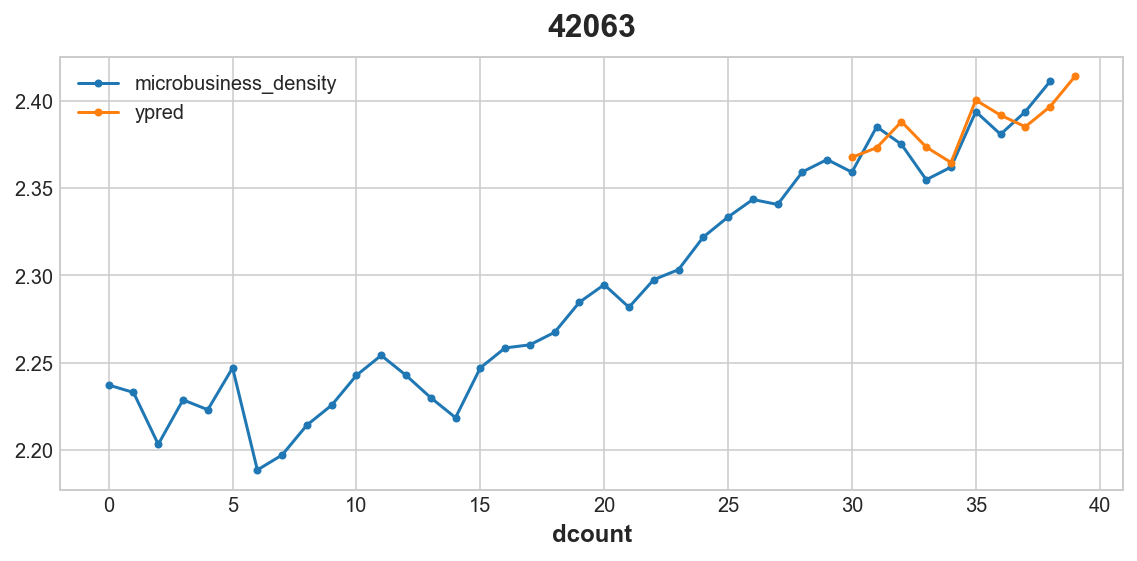

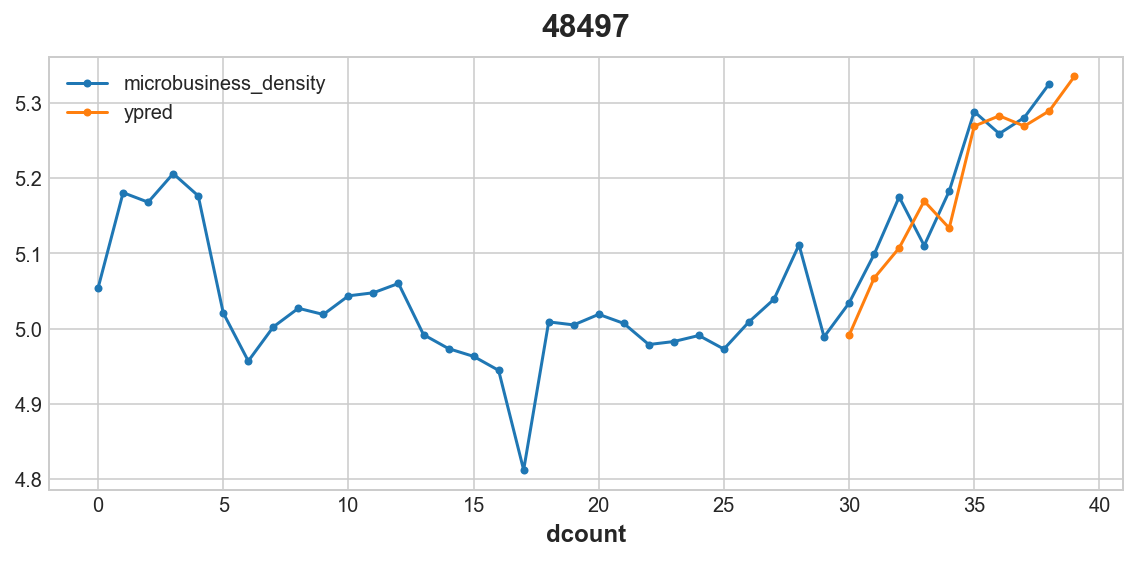

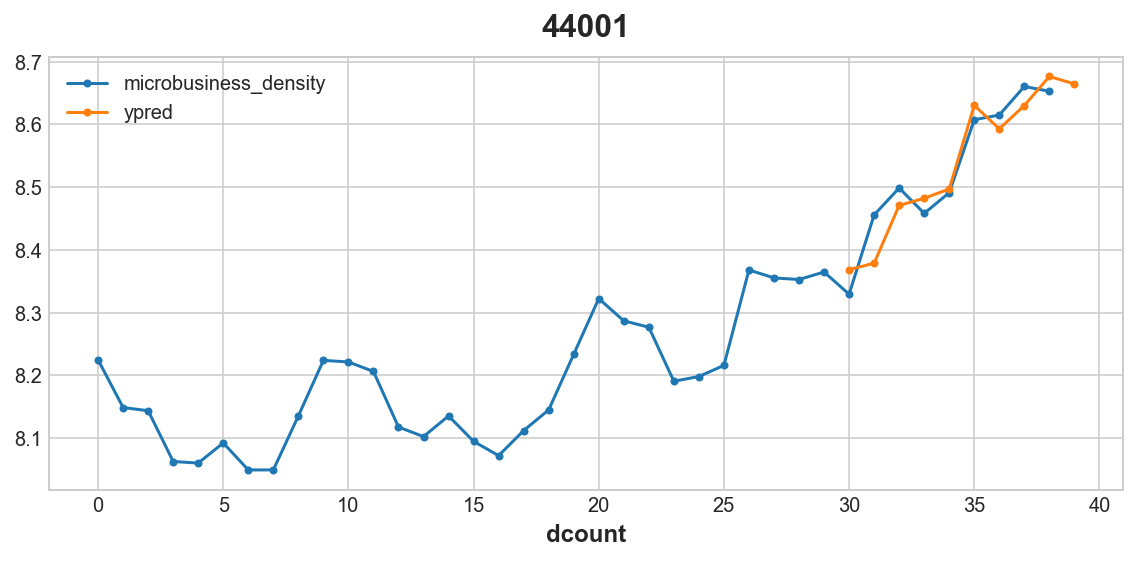

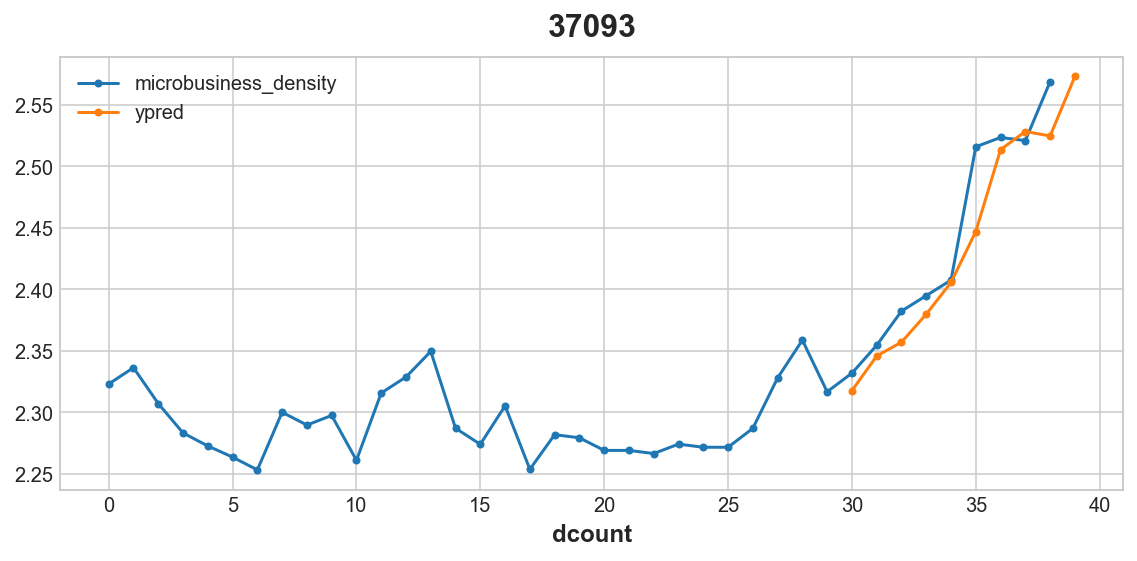

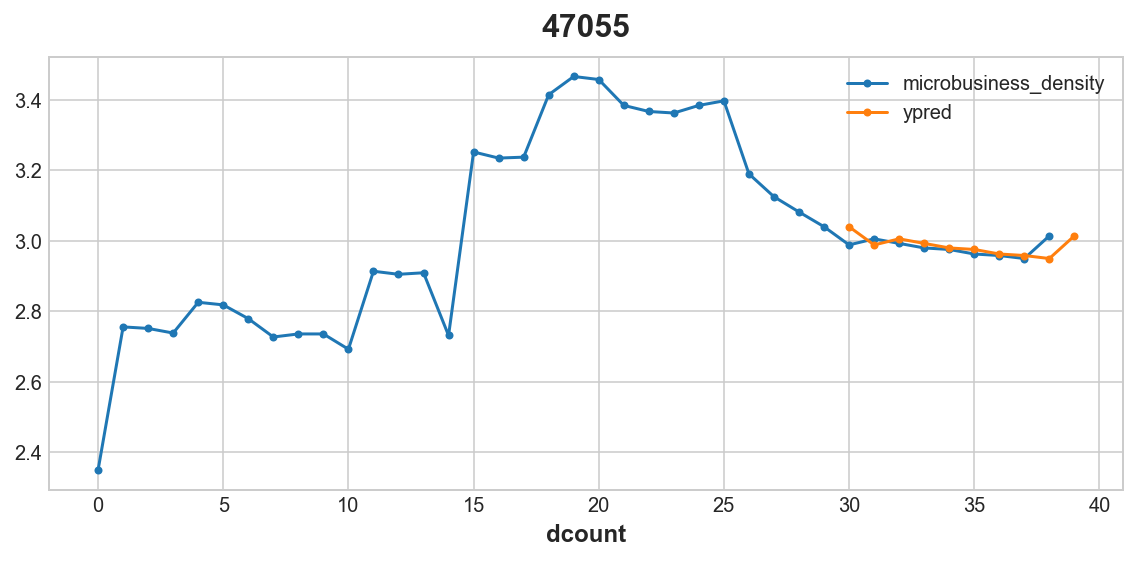

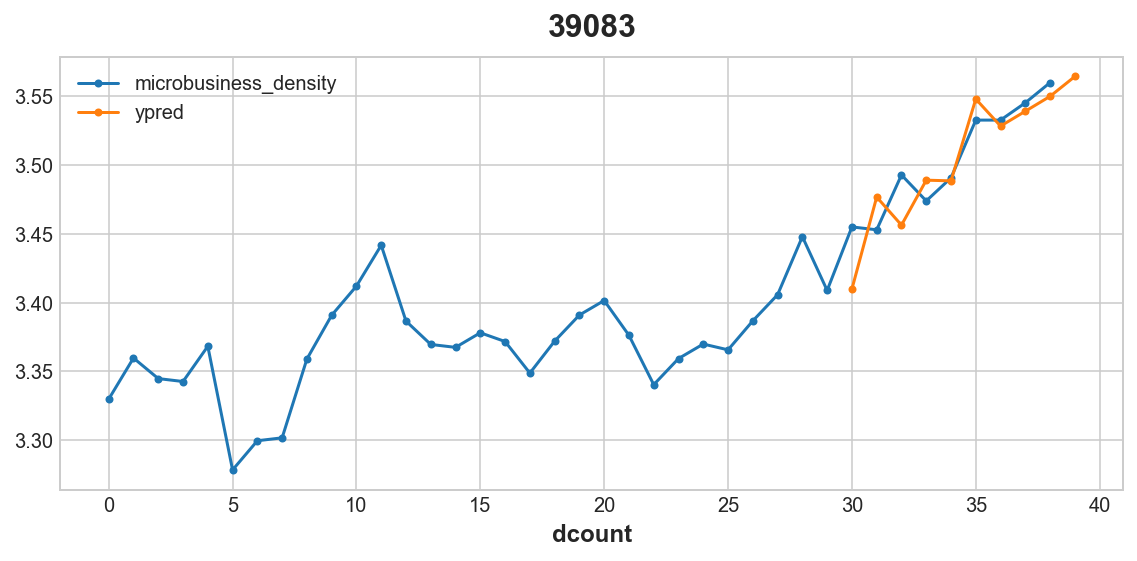

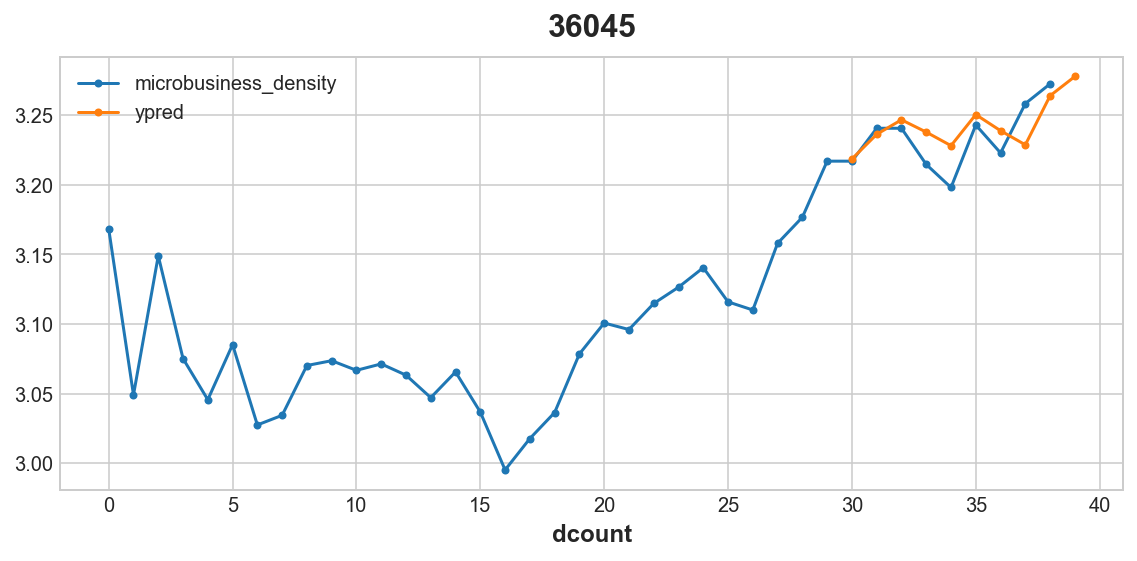

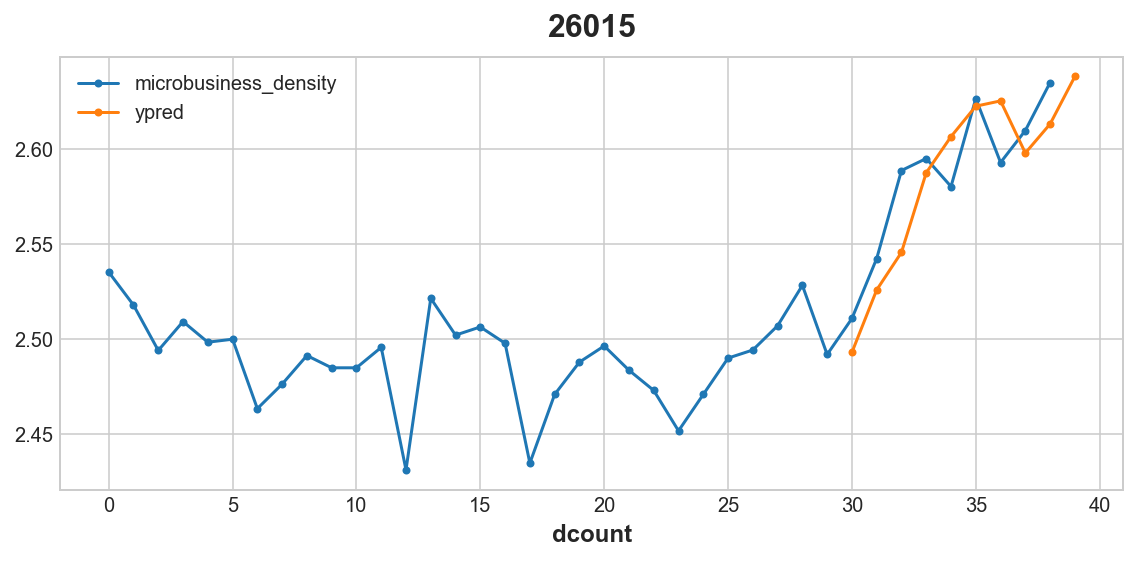

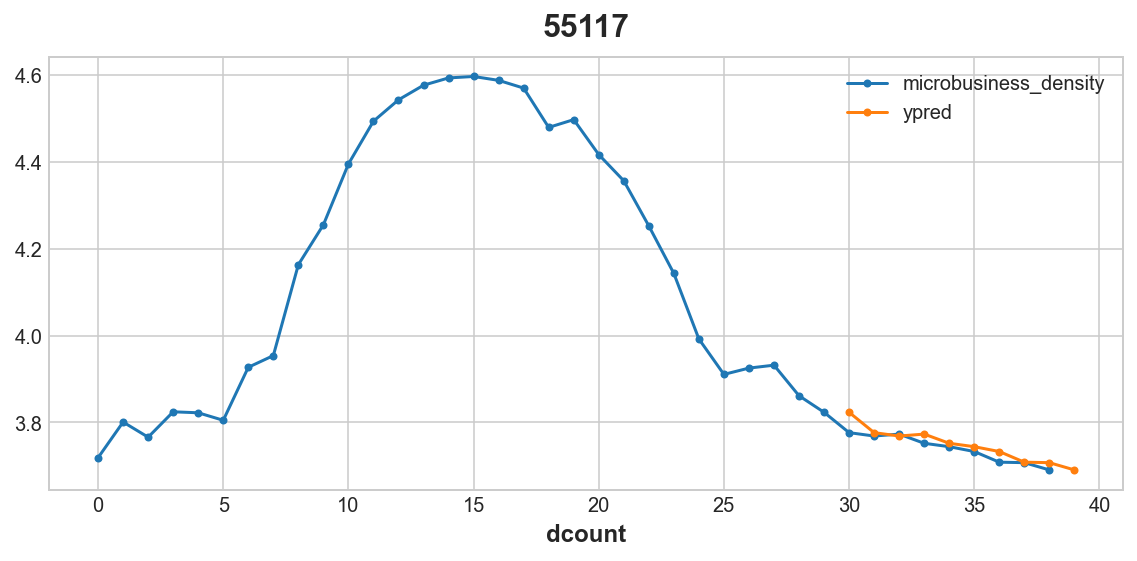

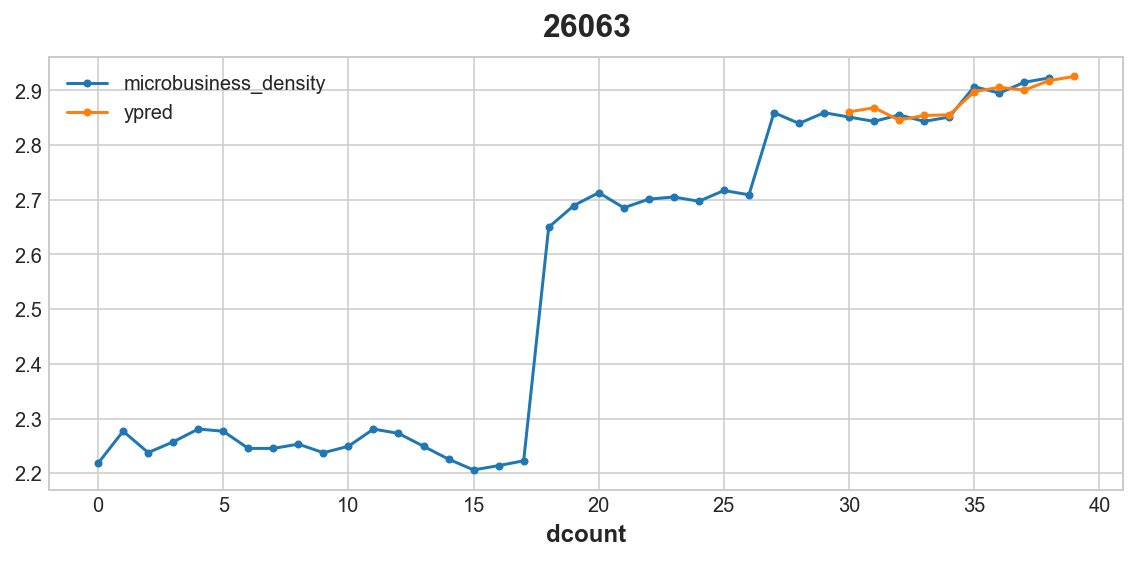

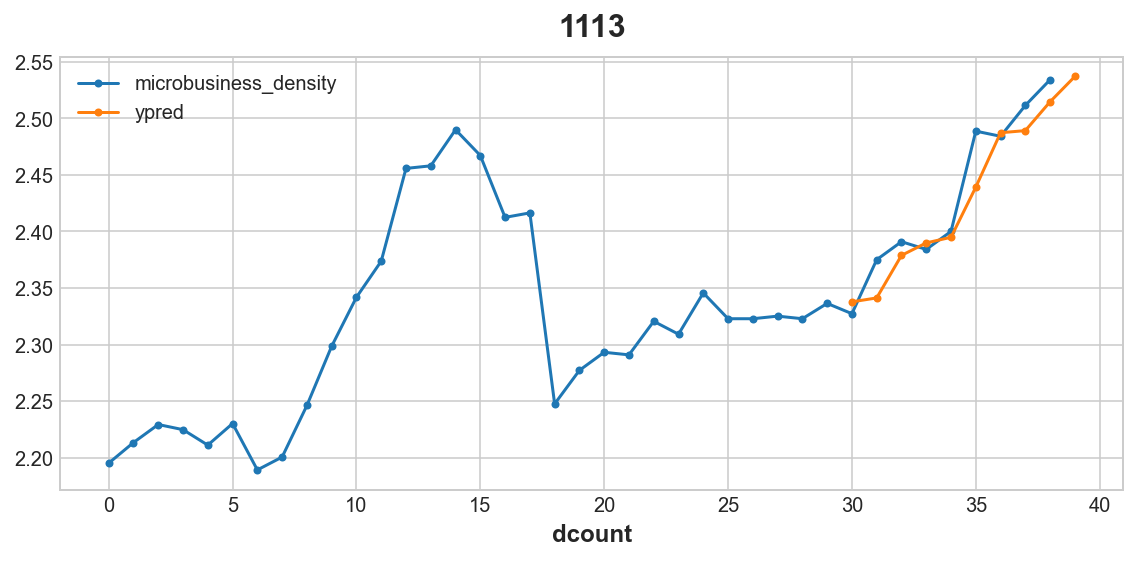

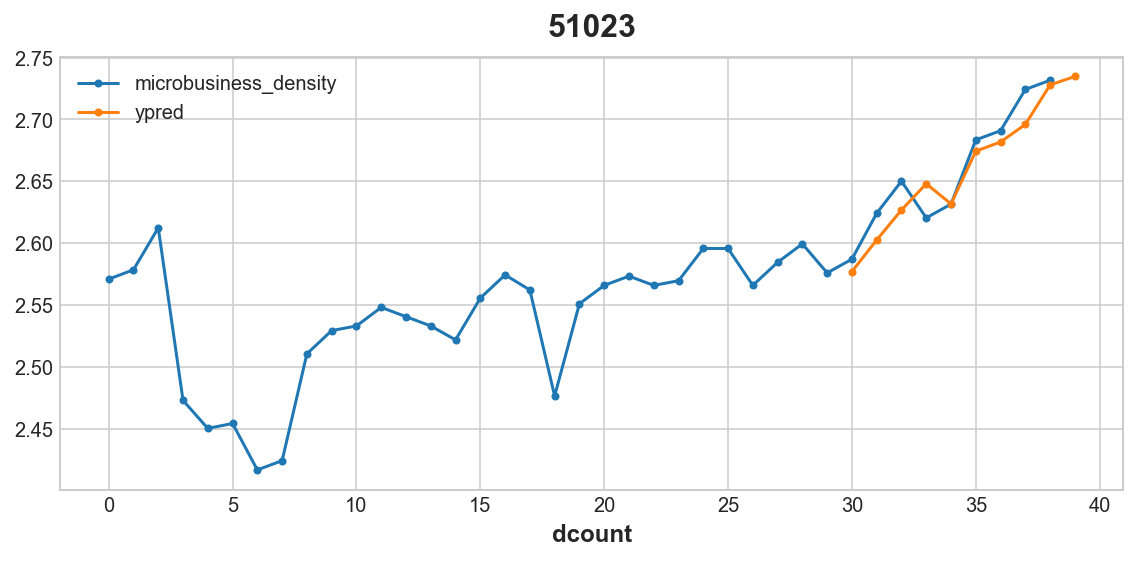

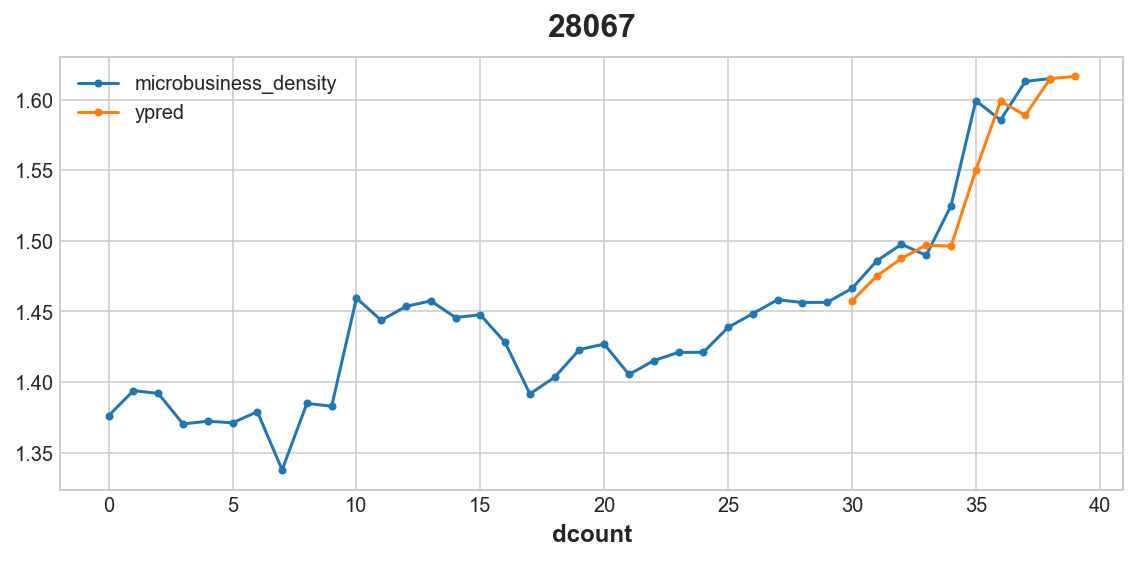

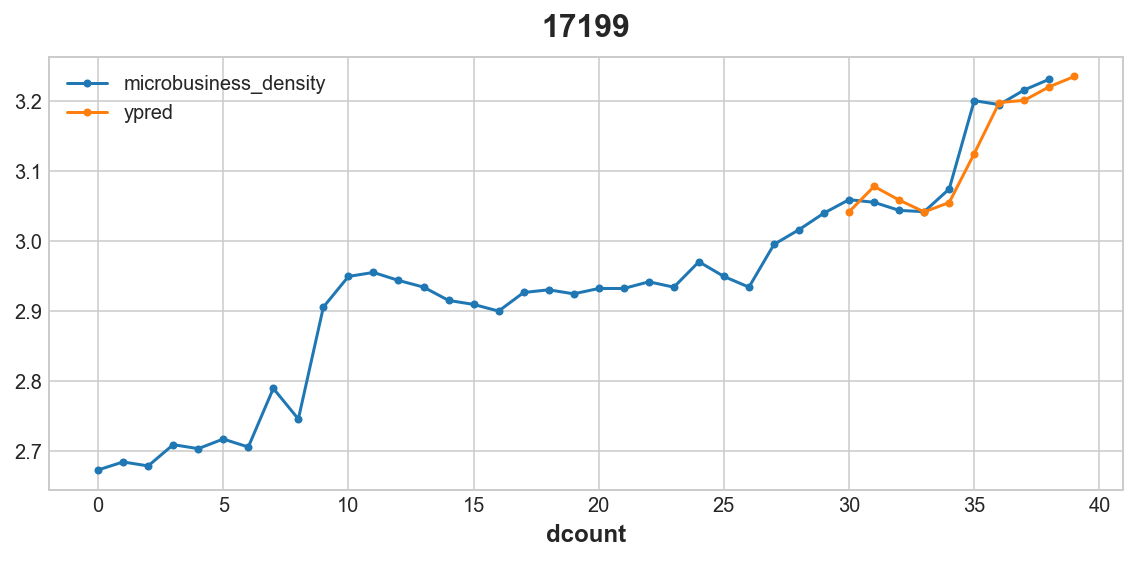

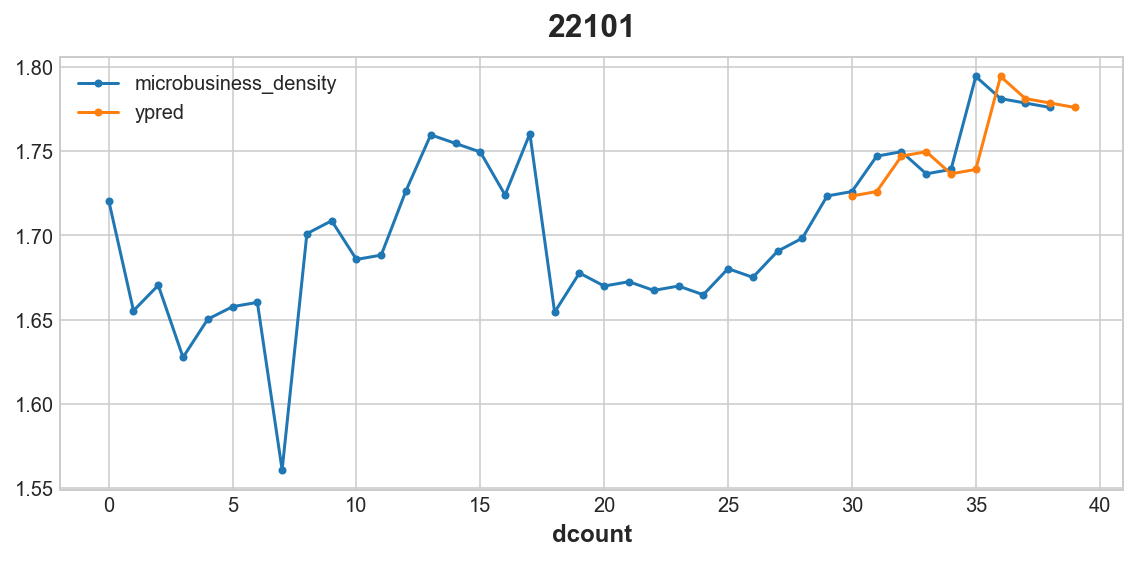

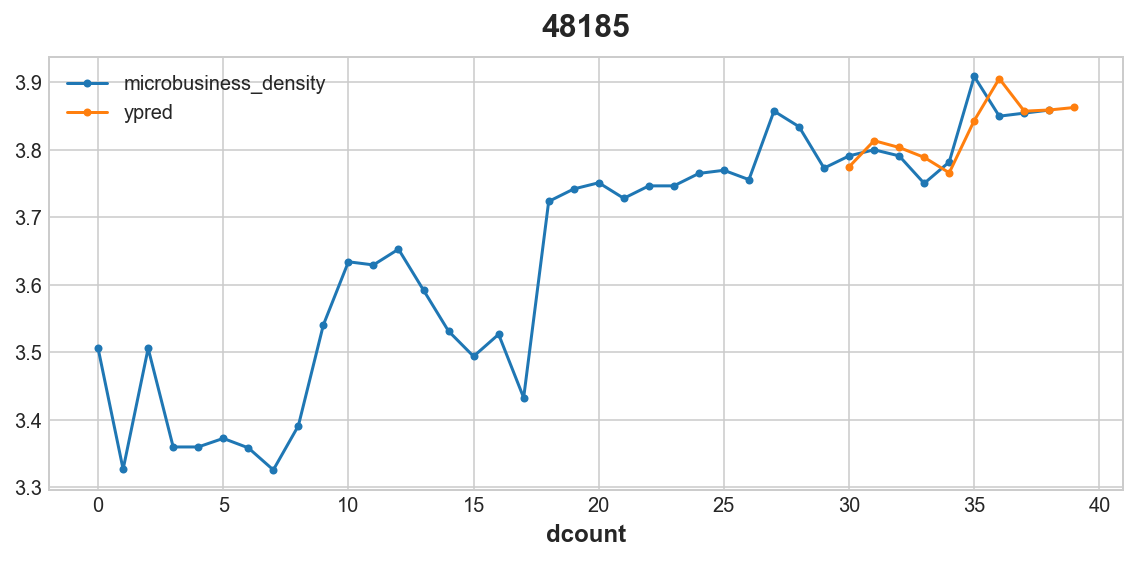

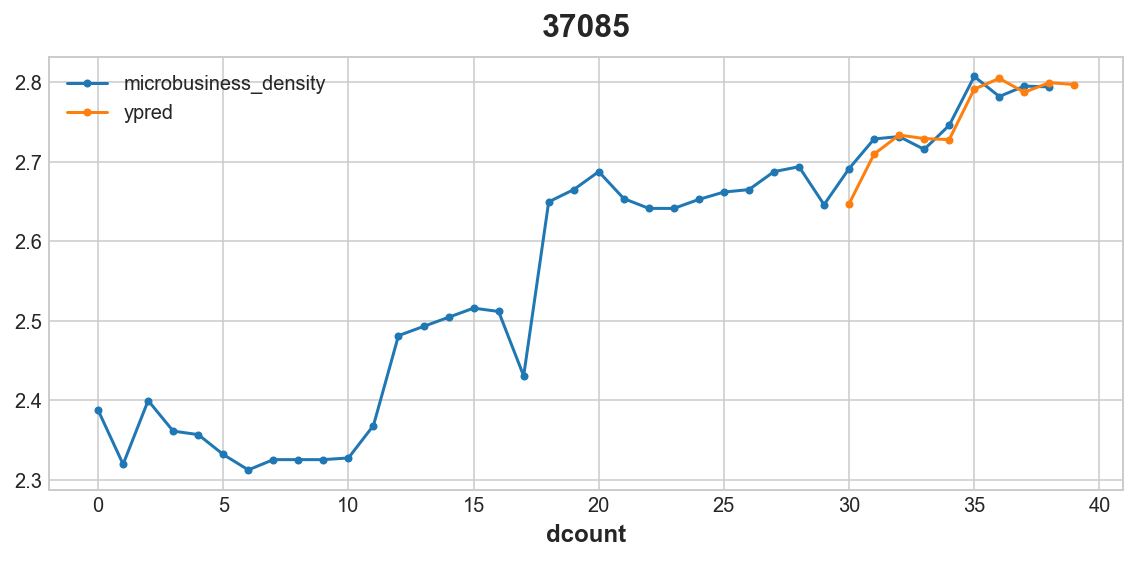

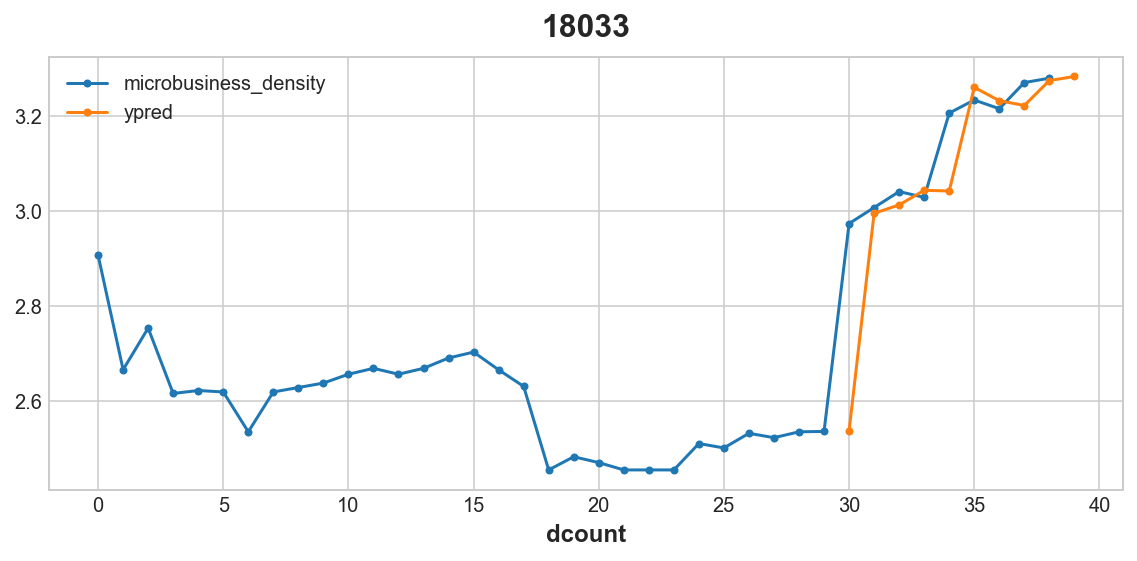

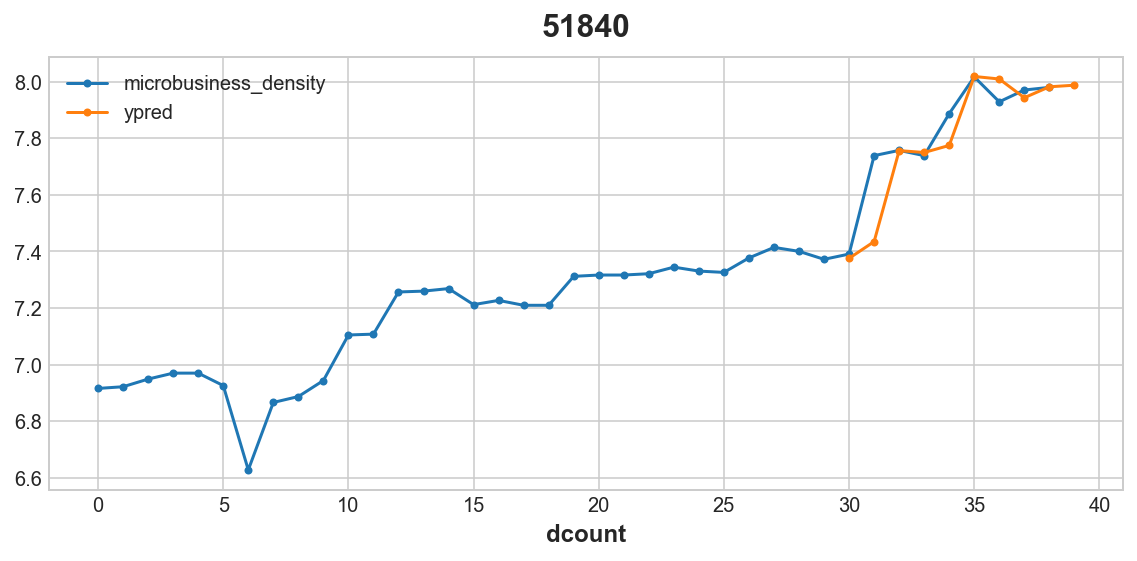

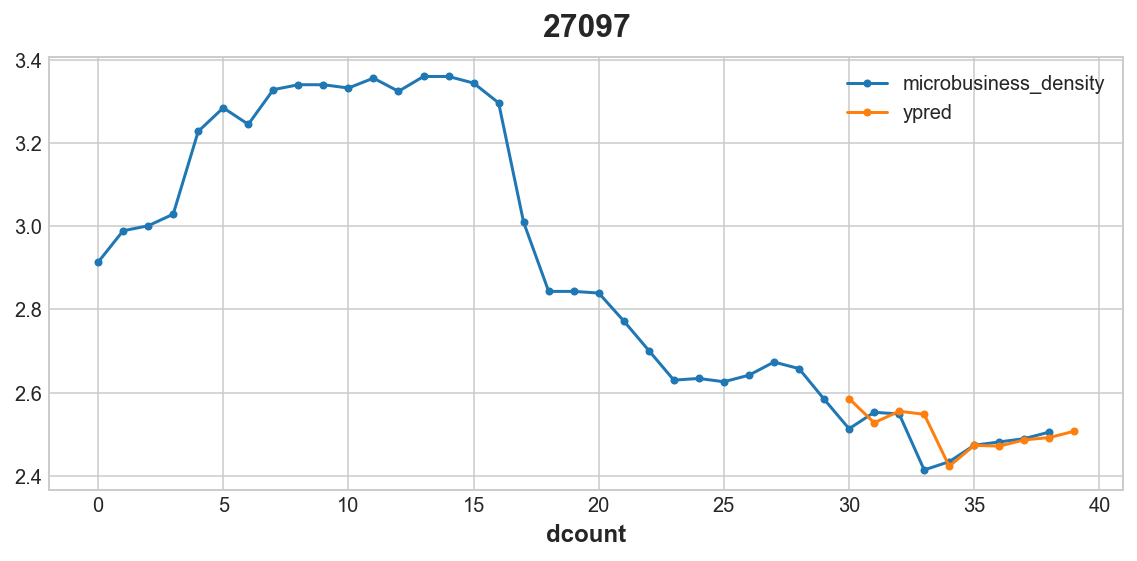

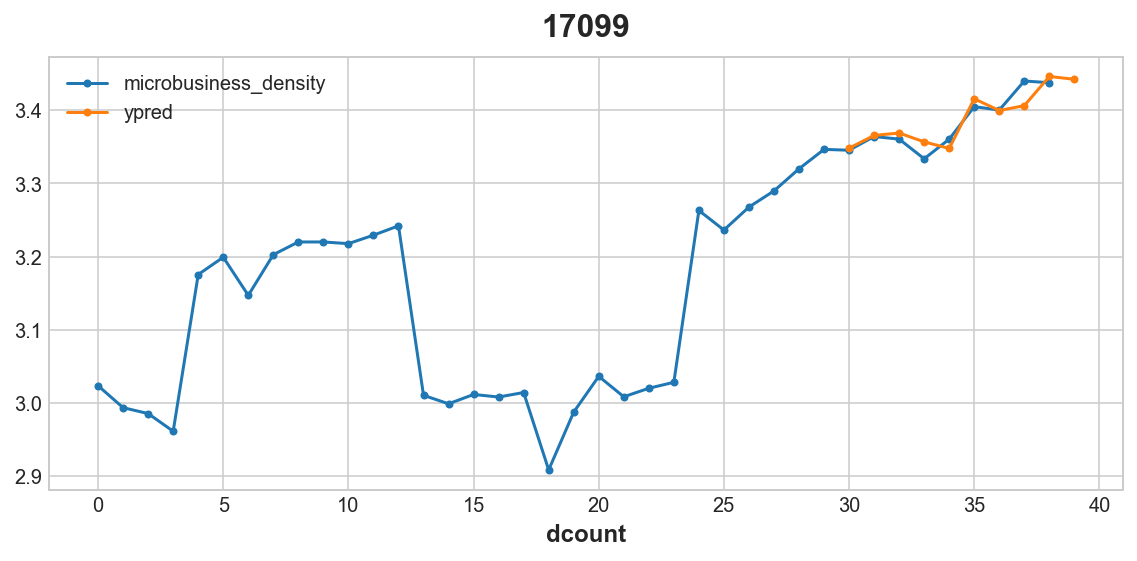

In [62]:
# show me the preds, WHY WHERE IS A LAG?????
for d in [16005, 20103,  1127, 24035, 47003,  5045, 36015, 51590, 51191,
            42063, 48497, 44001, 37093, 47055, 39083, 36045, 26015, 55117,
            26063,  1113, 51023, 28067, 17199, 22101, 48185, 37085, 18033,
            51840, 27097, 17099]:
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], style='.-', title=str(d))
    #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred_last'], title=str(d))

### LET'S GET THE PREDICTIONS FOR TS=38+1, WHICH IS 2022-11-01

In [38]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

(1104.888888888889, 800.0, [800, 583, 889, 3471, 636, 445, 1531, 694, 895])

In [39]:
best_rounds = 1500 #int(np.median( BEST_ROUNDS )+1)
best_rounds

1500

In [40]:
TS = 38
print(TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,  # now we have best round, so no early stopping
    learning_rate=0.0075,
    max_leaves = 31,           # the model used above has 17
    subsample=0.60,            # the model used above has 0.50 
    colsample_bytree=0.50,     
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',           
)

model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.dcount == TS)

# I don't understand why we need two identical models. and then do a half / half ensemble
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
)

model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features])) / 2

raw.loc[valid_indices, 'k'] = ypred + 1.0
raw.loc[valid_indices, 'var_pred'] = ypred
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density'] # this is the pred for TS+1 = 39, although it is at TS

# two mappings
# 1. each cfips' microbusiness density in TS
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
# 2. each cfips' TS+1 prediction
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

38


In [41]:
# raw.loc[raw.dcount == 38]

In [42]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df

,cfips,microbusiness_density,state,lastactive,mbd_lag_1
0,1001,NaN,Alabama,1472.0,NaN
1,1003,NaN,Alabama,14320.0,NaN
2,1005,NaN,Alabama,244.0,NaN
3,1007,NaN,Alabama,229.0,NaN
4,1009,NaN,Alabama,813.0,NaN
...,...,...,...,...,...
3130,56037,NaN,Wyoming,905.0,NaN
3131,56039,NaN,Wyoming,5035.0,NaN
3132,56041,NaN,Wyoming,582.0,NaN
3133,56043,NaN,Wyoming,189.0,NaN


In [43]:
df['pred'] = df['cfips'].map(dt)           # assign predictions to TS+1
df['lastval'] = df['cfips'].map(lastval)   # assign TS density values

In [44]:
# special cases when last_value s better than xgboos prediction
df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']

# assign values in raw dataframe
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [45]:
raw.loc[raw.dcount.isin([38,39]), ['cfips','microbusiness_density','dcount','ypred','ypred_last','k','var_pred']]

,cfips,microbusiness_density,dcount,ypred,ypred_last,k,var_pred
38,1001,3.463856,38,3.447505,3.442677,3.468315,0.001287
39,1001,NaN,39,3.468315,3.463856,1.000000,NaN
85,1003,8.359798,38,8.361896,8.341701,8.378893,0.002284
86,1003,NaN,39,8.378893,8.359798,1.000000,NaN
132,1005,1.232074,38,1.208462,1.206827,1.233287,0.000985
...,...,...,...,...,...,...,...
147243,56041,NaN,39,4.014271,4.009369,1.000000,NaN
147289,56043,3.126551,38,3.209264,3.209264,3.130557,0.001281
147290,56043,NaN,39,3.126551,3.126551,1.000000,NaN
147336,56045,1.785395,38,1.785395,1.785395,1.787047,0.000925


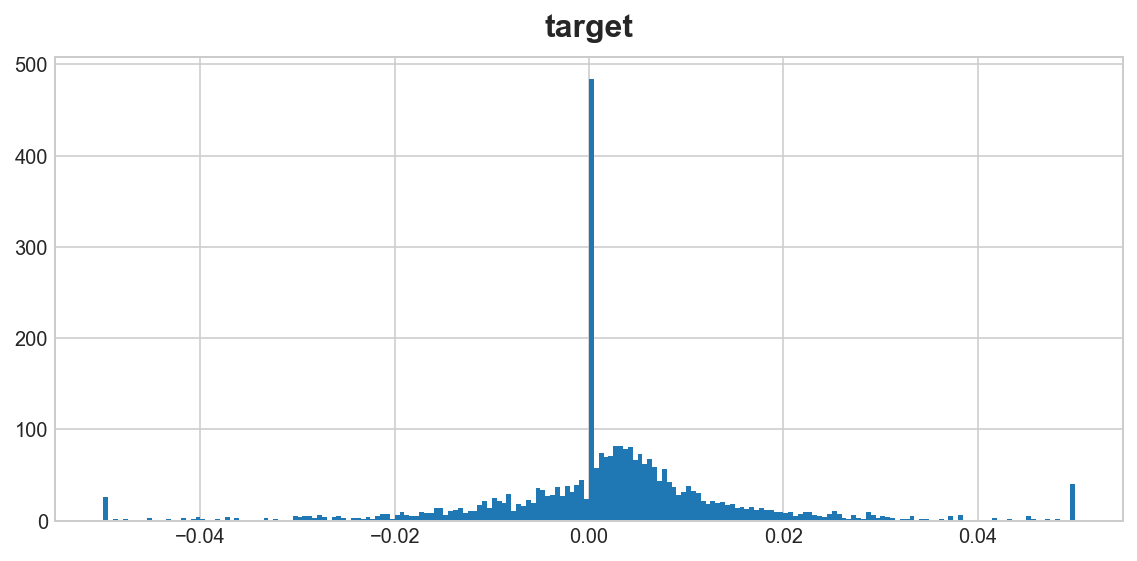

In [46]:
raw.loc[(raw.dcount==37), ['target']].clip(-0.05, 0.05).hist(bins=200);

var_pred mean:  var_pred    0.001215
dtype: float64


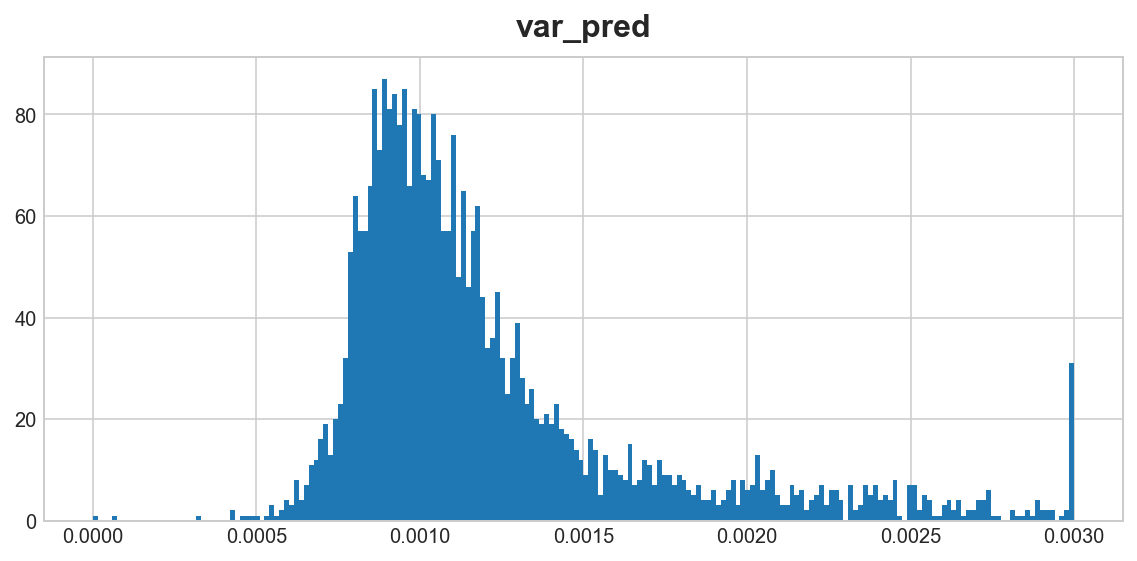

In [47]:
print('var_pred mean: ', raw.loc[raw.dcount==38, ['var_pred']].mean())
raw.loc[raw.dcount==38, ['var_pred']].clip(0, 0.003).hist(bins=200);

In [ ]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

# test.to_csv('./submission_files/submission_xgiba_mbd_modified_v0.csv', index=False)
test[['row_id','microbusiness_density']].to_csv('./submission_files/submission_xgiba_mbd_modified_v0.csv', index=False)
# test

In [ ]:
# raw.loc[raw.cfips.isin([28055,48269])].head(50)

#### Predictions by classes

In [59]:
lastvalue_baseline = pd.read_csv('./submission_files/lastvalue_baseline.csv')

extrahigh_high_medhigh_cfips = [
12011,48157,31055,9001,6111,36059,34003,6001,40143,42101,47037,8035,42003,25017,45019,24033,17197,10005,12071,48201,25025,
46099,11001,34013,32003,48029,48339,6067,48439,6061,48113,47157,12057,20091,39035,29189,12095,47187,36081,24510,37119,17043,
53053,12117,13067,49035,36047,34023,48491,6059,25027,39061,12021,51059,36119,36029,6065,6037,42029,24005,17097,6073,40109,
6083,12127,39049,8013,24013,42017,55079,36061,8069,6085,4013,34025,12086,13121,8059,41067,16001,6041,29095,8041,42091,36103,
21111,6013,48085,9009,48121,51107,4019,6071,13089,12009,18097,25009,27053,17031,15003,6081,25021,12031,12115,55025,6075,24031,
48453,26163,53061,9003,26081,36055,26125,12103,6097,49049,32510,34027,10003,8005,37183,34017,53033,41051,12001,8031,12099,13135,
  51510,13151,48257,37129,12085,16019,10001,13297,48027,47165,48039,27109,13139,39103,45015,51700,37081,55009,47189,
49057,34007,36067,12015,36005,34039,25023,41047,51153,48367,18081,12097,48181,53073,28049,48167,19101,48251,37035,39041,
34015,37175,30111,44007,34031,6077,12113,53057,37021,6079,24027,49053,6019,24021,12101,26139,36093,48139,45035,39165,31109,
13247,22033,45083,36111,1117,13059,37067,48309,45063,34001,28089,18089,16027,18163,13097,37051,51087,48329,6099,13215,44003,
28047,36087,42045,8123,37097,37147,13051,5007,47093,41017,16055,48183,37001,36085,6023,49011,18019,51013,33015,47149,22051,
42077,39113,12053,34029,42049,42019,34005,26099,39025,45079,51179,45045,51177,42041,36065,29165,22071,30063,27163,21067,
51550,17143,25003,13223,27019,29047,55139,48215,12131,47125,28033,13077,15009,37101,6107,12069,19153,6089,49005,28071,20173,
47119,48479,9011,42069,19049,48209,36071,36063,42125,39085,55087,48041,12111,33013,29510,18003,1089,2020,4025,6029,8001,51760,
56039,6053,42043,12083,48397,48061,41061,12081,24017,39099,17037,23031,44009,37179,6017,13073,45013,34009,34035,24003,39153,
39093,12105,27037,17201,36109,48187,12073,53005,48303,26093,19013,36079,37089,28121,1073,55133,32031,12033,6095,39133,53011,
26055,36001,22055,50007,27137,45051,5143,12109,18039,29099,30029,6057,47163,5119,48381,18127,22017,47065,34037,53063,18141,
51540,47179,12005,8105,36083,37071,20045,17163,46103,37135,27171,12019,33017,1081,9013,33009,36007,45091,27139,9005,18105,
42011,53029,39089,13063,12091,4005,39055,47009,18057,55101,13057,42095,8037,26021,17119,41005,34021,35049,27003,44005,50003,
1097,39095,29183,48423,51003,8014,25001,6113,31153,55059,9007,17111,48141,55089,51710,17113,12035,34019,42089,41039,24025,
35013,13113,34041,37063,13021,50027,17089,53077,1101,48091,49043,42133,4015,21117,26065,39057,8077,54039,42129,17093,48245,
51041,6055,47155,55127,36027,1003,18063,53067,33011,42079,4021,25013,56033,6007,42021,19103,38017,23005,53035,42027,30031,
21015,22019,26145,15001,56021,35001,48355,41029,32005,55131,17019,6087,35043,13157,26049,51810,26161,39017,17167,1125,51085,
26077,29077,25015,29019,41033,40017,8067,37019,12017,13245,12061,13117,27123,39151,19113,6033,22103,37025,12087,23019,18157,
19163,40027,15007,25005,42071,36091,41071,20177,   16021,51630,55135,22061,5125,53017,28059,40019,37127,30081,13217,22079,
45007,42117,49051,39075,13285,48199,13295,45037,25007,51061,27059,31025,12089,51165,42013,26047,18059,29043,54037,48013,41059,
53027,45041,13045,49021,17161,22113,39109,5009,21049,13103,20209,36037,46127,6069,23001,56025,37077,48021,22097,27005,55105,
40021,54029,6045,53025,38035,39169,42055,27061,26107,47105,17049,8029,47031,47147,37027,28073,1043,39043,13185,19099,45085,
18011,22073,46093,37161,48477,51187,40125,20037,16081,40097,29219,47113,39073,48493,28081,40087,37045,54035,55083,37059,24009,
51069,51650,22087,8113,48171,8045,13153,29225,39039,39155,47123,51127,48281,40071,40013,33001,46083,17133,55125,26137,39011,
24043,45055,8049,42075,30093,26115,56023,48277,33005,13013,54061,36097,40145,21185,20121,5031,8097,18005,56037,39145,22045,
17091,6039,37053,48007,48099,48349,45059,48291,48071,18109,27083,18035,45003,51089,12051,19139,1095,45075,35009,1001,23025,
48135,51683,51019,1031,51099,16083,16069,39139,46011,48037,54003,13031,51077,21209,48147,41053,27095,40111,49047,1033,13133,
51740,22005,51075,13127,19191,28045,16011,49029,37159,13145,48481,36021,1009,13211,29023,13029,47141,51031,42131,4027,16005,
20103,1127,24035,47003,5045,36015,51590,51191,42063,48497,44001,37093,47055,39083,36045,26015,55117,26063,1113,51023,28067,
17199,22101,48185,37085,18033,51840,27097,17099,30049,17001,13241,17195,34033,51800,47047,48015,13071,51047,26087,40131,13313,
51520,24023,55085,48467,22095,13095,48097,23011,12023,1083,6109,41057,6115,21037,21151,19167,41027,17085,42121,41035,29097,
50015,51730,37087,2170,49003,48217,40119,42103,26157,32017,48203,47011,13179,55095,37163,48471,40083,51680,48441,26091,51199,
37109,39147,47145,13291,29021,48231,55039,29159,53015,40137,26005,42005,26147,38059,55063,27015,1115,16057,56029,39063,55141,
53021,42039,37193,55027,37155,21029,55055,20191,13047,55021,
]

In [60]:
# mapping dict
dt = raw.loc[(raw.dcount==39) & (raw.cfips.isin(extrahigh_high_medhigh_cfips)), ['row_id', 'cfips', 'ypred']].sort_values('cfips')
lastvalue_baseline.loc[lastvalue_baseline.row_id.isin(dt.row_id),'microbusiness_density'] = dt['ypred'].values

lastvalue_baseline.to_csv('./submission_files/teste_extrahigh_high_medhigh_cfips_xgboost.csv', index=False)
